---

# Imports

---

In [1]:
import ollama
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from PIL import Image

import os
import time
import textwrap

In [2]:
print(ollama.list().models)
model = ollama.list().models[0].model
print(model)

[Model(model='nomic-embed-text:latest', modified_at=datetime.datetime(2025, 4, 13, 23, 46, 15, 419269, tzinfo=TzInfo(+02:00)), digest='0a109f422b47e3a30ba2b10eca18548e944e8a23073ee3f3e947efcf3c45e59f', size=274302450, details=ModelDetails(parent_model='', format='gguf', family='nomic-bert', families=['nomic-bert'], parameter_size='137M', quantization_level='F16')), Model(model='deepseek-r1:8b', modified_at=datetime.datetime(2025, 2, 25, 22, 59, 50, 296808, tzinfo=TzInfo(+01:00)), digest='28f8fd6cdc677661426adab9338ce3c013d7e69a5bea9e704b364171a5d61a10', size=4920738407, details=ModelDetails(parent_model='', format='gguf', family='llama', families=['llama'], parameter_size='8.0B', quantization_level='Q4_K_M')), Model(model='llama3.2-vision:11b', modified_at=datetime.datetime(2025, 2, 1, 15, 2, 8, 131305, tzinfo=TzInfo(+01:00)), digest='085a1fdae525a3804ac95416b38498099c241defd0f1efc71dcca7f63190ba3d', size=7901829417, details=ModelDetails(parent_model='', format='gguf', family='mllama',

---

# Code / Fonctions Necessaires

---

In [23]:
def get_vector(model, text):
    return np.array(ollama.embed(
        model=model,
        input=text,
    )["embeddings"]).flatten()

def get_difference(v1, v2):
    return np.linalg.norm(v1 - v2)

def get_angular_difference(v1, v2):
    return 1 - np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

def compress_to_2d(vector):
    n = len(vector)
    return np.array([vector[0:n//2].mean(), vector[n//2:].mean()])

def difference_between_words(word1, word2):
    v1 = get_vector(model, word1)
    v2 = get_vector(model, word2)
    return float(get_difference(v1, v2))

def angular_difference_between_words(word1, word2):
    v1 = get_vector(model, word1)
    v2 = get_vector(model, word2)
    return float(get_angular_difference(v1, v2))

def plot_word_differences(word1_list, word2_list, figsize=(6, 5), cmap='autumn_r', cmin=0.3, func=get_difference):
    word1_embeds = [get_vector(model, word) for word in word1_list]
    word2_embeds = [get_vector(model, word) for word in word2_list]

    differences = np.zeros((len(word1_list), len(word2_list)))

    for i in range(len(word1_list)):
        for j in range(len(word2_list)):
            differences[i][j] = func(word1_embeds[i], word2_embeds[j])

    plt.figure(figsize=figsize)

    hist = plt.hist2d(
        np.tile(range(len(word2_list)), len(word1_list)),
        np.repeat(range(len(word1_list)), len(word2_list)),
        bins=(len(word2_list), len(word1_list)),
        weights=differences.flatten(),
        cmap=cmap,
        cmin=cmin,
    )
    
    plt.title('Semantic Difference Between Strings')
    plt.xticks(range(len(word2_list)), word2_list, rotation=45)
    plt.yticks(range(len(word1_list)), word1_list)
    plt.xlabel('String 2')
    plt.ylabel('String 1')
    plt.colorbar(hist[3])
    plt.show()

def analyze_word_and_description(word, word_description):
    hammer_embedding = get_vector(model, word)
    hammer_2d = compress_to_2d(hammer_embedding)

    hammer_desc = word_description.split()
    hammer_desc_embeddings = [get_vector(model, " ".join(hammer_desc[0:i+1])) for i in range(0, len(hammer_desc))]
    hammer_desc_2d = [compress_to_2d(h) for h in hammer_desc_embeddings]

    plt.figure(figsize=(15, 10))
    plt.title('Compressed 2D vectors')
    plt.xlabel("Mean of first half of vector")
    plt.ylabel("Mean of second half of vector")
    plt.grid()
    plt.axhline(0, color='black', lw=2)
    plt.axvline(0, color='black', lw=2)
    plt.scatter(hammer_2d[0], hammer_2d[1], color='red', label=word)
    plt.annotate(word, (hammer_2d[0], hammer_2d[1]), fontsize=20, ha='left', va='top', color="red")

    for i, d in enumerate(hammer_desc_2d):
        color = (i / len(hammer_desc), 0, 1 - i / len(hammer_desc))
        if i != 0 and i != len(hammer_desc) - 1:
            plt.scatter(d[0], d[1], color=color, alpha=0.5, label=" ".join(hammer_desc[0:i+1]))
        else:
            plt.scatter(d[0], d[1], color=color, alpha=0.5, label=" ".join(hammer_desc[0:i+1]), marker='x', s=100)

    plt.legend()
    plt.show()

    # Plot the difference between the word and the word description embeddings, as more words get added
    plt.figure(figsize=(10, 5))
    plt.title('Difference between Word and Word Description')
    plt.xlabel("Number of words in description")
    plt.ylabel("Difference")
    plt.xticks(range(len(hammer_desc)), range(len(hammer_desc)))
    plt.grid()
    plt.axhline(0, color='black', lw=0.5)
    plt.plot(
        range(len(hammer_desc)),
        [get_difference(np.array(x).flatten(), hammer_embedding) for x in hammer_desc_embeddings],
        marker='o',
        label='Difference',
    )
    plt.show()

def analyze_word_and_wordlist(word, alternative_words, figsize=(15, 10)):
    hammer_embedding = get_vector(model, word)
    hammer_2d = compress_to_2d(hammer_embedding)

    hammer_desc = alternative_words
    hammer_desc_embeddings = [get_vector(model, w) for w in hammer_desc]
    hammer_desc_2d = [compress_to_2d(h) for h in hammer_desc_embeddings]

    differences = [get_difference(hammer_embedding, h) for h in hammer_desc_embeddings]
    min_diff = min(differences)
    max_diff = max(differences)
    diff_range = max_diff - min_diff

    plt.figure(figsize=figsize)
    plt.title('Compressed 2D vectors')
    plt.xlabel("Mean of first half of vector")
    plt.ylabel("Mean of second half of vector")
    plt.grid()
    plt.axhline(0, color='black', lw=2)
    plt.axvline(0, color='black', lw=2)
    plt.scatter(hammer_2d[0], hammer_2d[1], color='red', label=word)
    plt.annotate(word, (hammer_2d[0], hammer_2d[1]), fontsize=20, ha='left', va='top', color="red")

    for i, d in enumerate(hammer_desc_2d):
        diff = differences[i]
        color = (1 - ((diff - 0.3) / 1.2), 0, (diff - 0.3) / 1.2)
        plt.scatter(d[0], d[1], color=color, alpha=0.5, label=hammer_desc[i] + f"(Diff: {diff:.2f})", marker='x', s=100)
        plt.annotate(hammer_desc[i], (d[0], d[1]), fontsize=10, ha='center', va='top', color=color)


    plt.legend()
    plt.show()

    #colors = [(1, 1 - (diff - min_diff) / diff_range, 0) for diff in differences]
    colors = plt.cm.RdYlGn_r((np.array(differences) - min_diff) / diff_range)

    plt.figure(figsize=(10, 5))
    plt.title(f'Difference between "{word}" and Alternative Words')
    plt.xlabel("Alternative Word")
    plt.ylabel("Difference")
    plt.ylim(0.3, 1.2)
    plt.xticks(range(len(hammer_desc)), hammer_desc, rotation=30)
    plt.bar(
        range(len(hammer_desc)),
        differences,
        color=colors,
        label='Difference',
        edgecolor="black",
        linewidth=0.5,
    )
    plt.show()

def read_csv(file_path):
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        return df
    else:
        print(f"File {file_path} does not exist.")
        return None
    
def get_diff_for_model_prompt_image(df, model_name, prompt, image_name, diff_type="difference"):
    return df[(df["model"] == model_name) & (df["prompt"] == prompt) & (df["image_name"] == image_name)][diff_type].iloc[0]
    
def show_img(photo_id):
    try:
        img_path = "images/" + responses["image_name"].unique()[photo_id]
        img = Image.open(img_path)
        plt.figure(figsize=(8, 8))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Image: {responses['image_name'].unique()[photo_id]}")
        plt.show()
    except FileNotFoundError:
        print(f"Image file not found: {img_path}")
          
def compare_model_responses(df, prompt_id, photo_id, diff_type="difference"):
    prompt_id = prompt_id%len(df["prompt"].unique())
    photo_id = photo_id%len(df["image_name"].unique())
    image_name = df["image_name"].unique()[photo_id]
    prompt = df["prompt"].unique()[prompt_id]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    try:
        img_path = "images/" + image_name
        img = Image.open(img_path)
        ax1.imshow(img)
        ax1.axis('off')
        ax1.set_title(f"Image: {image_name}", fontsize=20, fontweight="bold")
    except FileNotFoundError:
        ax1.text(0.5, 0.5, f"Image file not found: {img_path}", 
                 ha='center', va='center', fontsize=20, fontweight="bold")
        ax1.axis('off')
    
    expected_desc = df[(df["prompt"] == prompt) & (df["image_name"] == image_name)]["correct_object_names"].iloc[0]
    ax2.grid(axis="y")
    ax2.set_title(f"Model responses and embedding differences\nExpected descriptions: {expected_desc}\nPrompt: {prompt}\n")
    ax2.set_ylabel("Difference")
    ax2.tick_params(axis='x', rotation=45)
    
    res = []
    for i, m in enumerate(df["model"].unique()):
        model_diff = get_diff_for_model_prompt_image(df, m, prompt, image_name, diff_type)
        res.append(model_diff)
        label = df[(df["model"] == m) & (df["prompt"] == prompt) & (df["image_name"] == image_name)]["model_response"].iloc[0]
        if len(label) > 100:
            label = textwrap.shorten(label, width=100, placeholder="...")
        label = label.replace("\n", " ")
        success = df[(df["model"] == m) & (df["prompt"] == prompt) & (df["image_name"] == image_name)]["success"].iloc[0]
        ax2.bar(
            m,
            model_diff,
            zorder=5,
            color=colors[i % len(colors)],
            edgecolor="black",
            linewidth=0.5,
            label=label,
        )
        ax2.annotate(
            f"{model_diff:.2f}",
            (i, model_diff),
            textcoords="offset points",
            xytext=(0, 10),
            ha='center',
            fontsize=12,
            color="black",
        )
        marker = "✔" if success else "✘"
        marker_color = "green" if success else "red"
        ax2.annotate(
            marker,
            (i, model_diff),
            textcoords="offset points",
            xytext=(0, 25),
            ha='center',
            fontsize=14,
            color=marker_color,
            fontweight='bold',
        )
    
    if diff_type == "difference":
        ax2.set_ylim(0, 1.3)
    elif diff_type == "angular_difference":
        ax2.set_ylim(0, 0.9)
    ax2.legend(
        loc='upper left', bbox_to_anchor=(1, 1), fontsize=10, title="Model Responses",
        title_fontsize='13', frameon=True, shadow=True, fancybox=True, borderpad=1,
        facecolor='lightgray', edgecolor='black', labelspacing=1.2
    )
    
    plt.tight_layout()
    plt.show()
    
    return res

def full_guesser(df, index, threshold=0.3974):
    row = df.iloc[index]
    model_name = row["model"]
    prompt = row["prompt"]
    success = row["success"]
    angular_diff = row["angular_difference"]

    image_name = row["image_name"]
    image_path = "images/" + image_name
    
    model_response = row["model_response"]
    correct_object_names = row["correct_object_names"]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8), gridspec_kw={'width_ratios': [3, 2]})

    try:
        image = Image.open(image_path)
        ax1.imshow(image)
        ax1.axis('off')
        ax1.set_title(f"Image: {image_name}", fontsize=20, fontweight="bold")
    except FileNotFoundError:
        ax1.text(0.5, 0.5, "Image not found", ha="center", va="center", fontsize=20)
        ax1.axis('off')

    ax2.axis('off')
    ax2.text(0.1, 0.9, f"Model: {model_name}", fontsize=16, fontweight="bold")
    ax2.text(0.1, 0.85, f"ID: {index}", fontsize=16, fontweight="bold")

    ax2.text(0.1, 0.80, f"Prompt:", fontsize=16, fontweight="bold")
    wrapped_prompt = textwrap.fill(prompt, width=50)
    ax2.text(0.1, 0.77, wrapped_prompt, fontsize=12, verticalalignment="top")

    ax2.text(0.1, 0.60, "Model Response:", fontsize=16, fontweight="bold")
    wrapped_response = model_response[:300] + "..." if len(model_response) > 300 else model_response
    wrapped_response = textwrap.fill(wrapped_response, width=50)
    ax2.text(0.1, 0.57, wrapped_response, fontsize=12, verticalalignment="top")

    ax2.text(0.1, 0.30, "Correct Object Names:", fontsize=16, fontweight="bold")
    wrapped_objects = textwrap.fill(correct_object_names, width=50)
    ax2.text(0.1, 0.27, wrapped_objects, fontsize=12, verticalalignment="top")

    if angular_diff < threshold:
        ax2.text(0.1, 0.17, f"Angular Difference:    {angular_diff:.2f} < {threshold}", fontsize=16, fontweight="bold", color="g")
    else:
        ax2.text(0.1, 0.17, f"Angular Difference:    {angular_diff:.2f} > {threshold}", fontsize=16, fontweight="bold", color="r")

    if success:
        ax2.text(0.1, 0.12, f"Success (word match): {success}", fontsize=16, fontweight="bold", color="g")
    else:
        ax2.text(0.1, 0.12, f"Success (word match): {success}", fontsize=16, fontweight="bold", color="r")
        
    final_success = True if success else angular_diff < threshold
    if final_success:
        ax2.text(0.1, 0.07, f"Final Success: {final_success}", fontsize=16, fontweight="bold", color="g")
    else:
        ax2.text(0.1, 0.07, f"Final Success: {final_success}", fontsize=16, fontweight="bold", color="r")

    ax2.add_patch(plt.Rectangle((0.05, 0.05), 0.9, 0.9, fill=False, edgecolor='black', linewidth=2))

    plt.suptitle(f"Model Response Success with threshold: {ang_diff_threshold}", fontsize=20, fontweight="bold", color="red", y=1.005)
    plt.tight_layout()
    plt.show()


---

# Demonstrations du concept "Embedding"

---

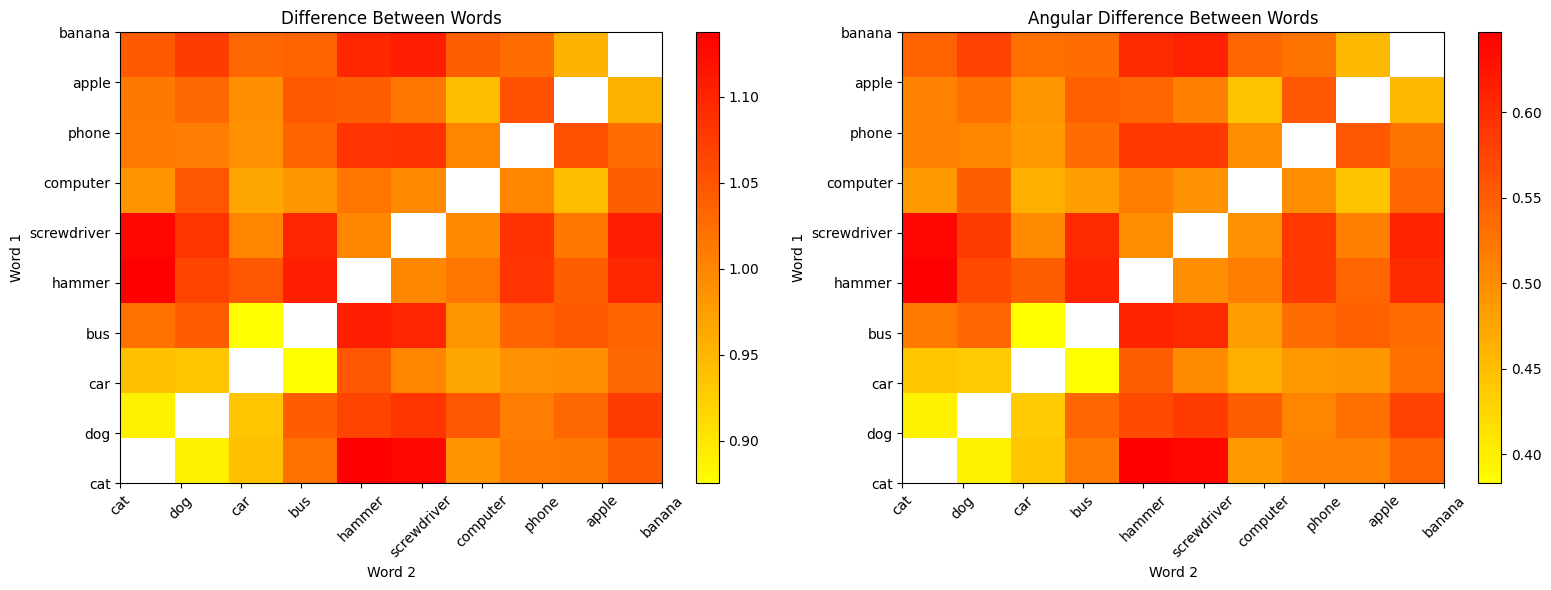

In [7]:
word1_list = ["cat", "dog", "car", "bus", "hammer", "screwdriver", "computer", "phone", "apple", "banana"]
word2_list = ["cat", "dog", "car", "bus", "hammer", "screwdriver", "computer", "phone", "apple", "banana"]

word1_embeds = [get_vector(model, word) for word in word1_list]
word2_embeds = [get_vector(model, word) for word in word2_list]

differences = np.zeros((len(word1_list), len(word2_list)))
angular_differences = np.zeros((len(word1_list), len(word2_list)))

for i, word1 in enumerate(word1_list):
    for j, word2 in enumerate(word2_list):
        differences[i][j] = get_difference(word1_embeds[i], word2_embeds[j])
        angular_differences[i][j] = get_angular_difference(word1_embeds[i], word2_embeds[j])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

hist1 = ax1.hist2d(
    np.repeat(range(len(word2_list)), len(word1_list)),
    np.tile(range(len(word1_list)), len(word2_list)),
    bins=(len(word2_list), len(word1_list)),
    weights=differences.flatten(),
    cmap='autumn_r',
    cmin=0.3
)
ax1.set_title('Difference Between Words')
ax1.set_xticks(range(len(word2_list)))
ax1.set_xticklabels(word2_list, rotation=45)
ax1.set_yticks(range(len(word1_list)))
ax1.set_yticklabels(word1_list)
ax1.set_xlabel('Word 2')
ax1.set_ylabel('Word 1')
plt.colorbar(hist1[3], ax=ax1)

hist2 = ax2.hist2d(
    np.repeat(range(len(word2_list)), len(word1_list)),
    np.tile(range(len(word1_list)), len(word2_list)),
    bins=(len(word2_list), len(word1_list)),
    weights=angular_differences.flatten(),
    cmap='autumn_r',
    cmin=0.3
)
ax2.set_title('Angular Difference Between Words')
ax2.set_xticks(range(len(word2_list)))
ax2.set_xticklabels(word2_list, rotation=45)
ax2.set_yticks(range(len(word1_list)))
ax2.set_yticklabels(word1_list)
ax2.set_xlabel('Word 2')
ax2.set_ylabel('Word 1')
plt.colorbar(hist2[3], ax=ax2)

plt.tight_layout()
plt.show()

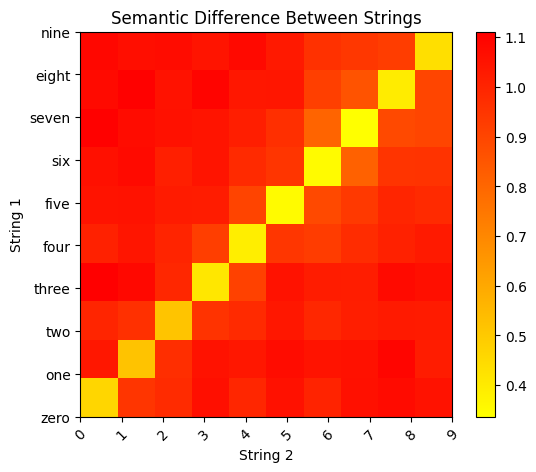

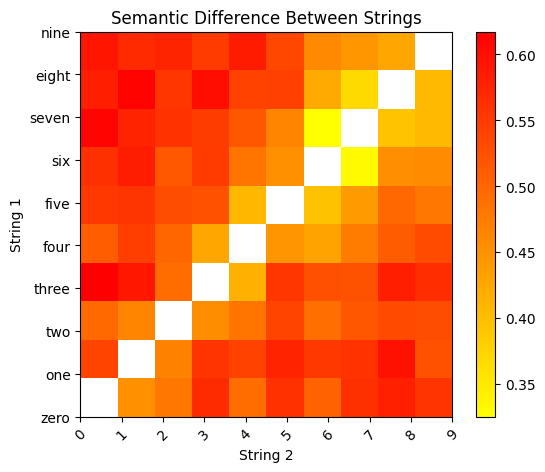

In [8]:
word1_list = ["zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]
word2_list = [str(i) for i in range(10)]
plot_word_differences(word1_list, word2_list, func=get_difference)
plot_word_differences(word1_list, word2_list, func=get_angular_difference)

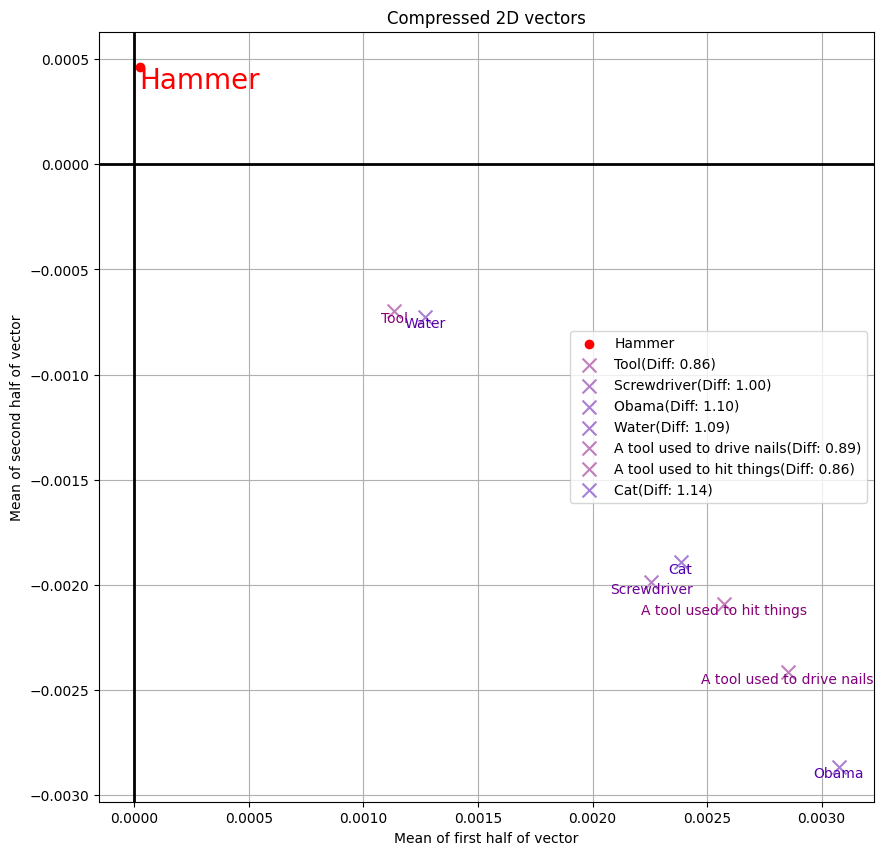

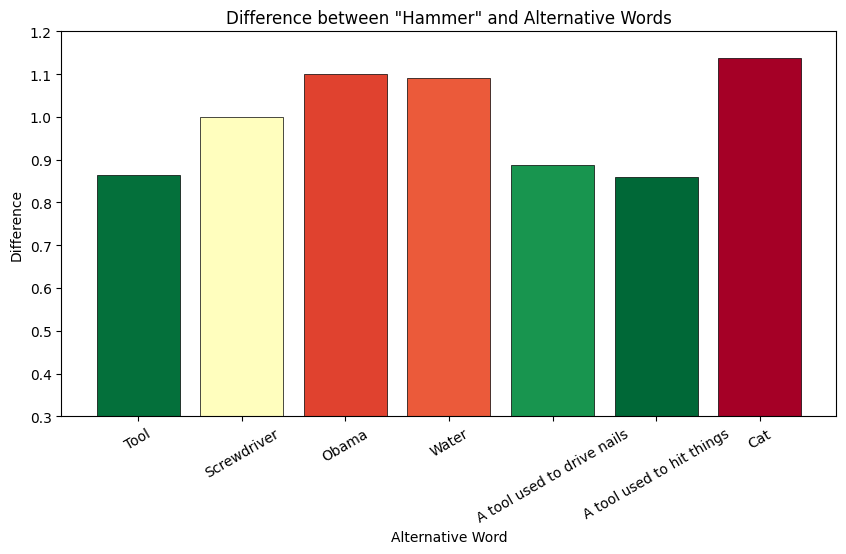

In [4]:
wordlist = ["Tool", "Screwdriver", "Obama", "Water", "A tool used to drive nails",
             "A tool used to hit things", "Cat"]
analyze_word_and_wordlist("Hammer", wordlist, figsize=(10, 10))

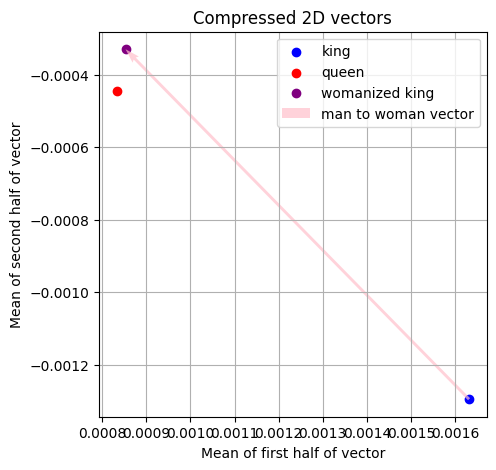

In [9]:
king_embedding = get_vector(model, "king")
queen_embedding = get_vector(model, "queen")

king_2d = compress_to_2d(king_embedding)
queen_2d = compress_to_2d(queen_embedding)

man_embedding = get_vector(model, "man")
woman_embedding = get_vector(model, "woman")

king_queen_difference = get_difference(king_embedding, queen_embedding)
man_woman_difference = get_difference(man_embedding, woman_embedding)

king_to_queen_vector = queen_embedding - king_embedding
man_to_woman_vector = woman_embedding - man_embedding

mtw_2d = compress_to_2d(man_to_woman_vector)

womanized_king_vector = king_embedding + man_to_woman_vector
womanized_man_vector = man_embedding + king_to_queen_vector

womanized_king_2d = compress_to_2d(womanized_king_vector)
womanized_man_2d = compress_to_2d(womanized_man_vector)

plt.figure(figsize=(5, 5))
plt.title('Compressed 2D vectors')
plt.xlabel("Mean of first half of vector")
plt.ylabel("Mean of second half of vector")
plt.grid()
plt.scatter(king_2d[0], king_2d[1], color='blue', label='king')
plt.scatter(queen_2d[0], queen_2d[1], color='red', label='queen')
plt.scatter(womanized_king_2d[0], womanized_king_2d[1], color='purple', label='womanized king')
plt.quiver(king_2d[0], king_2d[1], mtw_2d[0], mtw_2d[1], angles='xy', scale_units='xy', scale=1, color='pink', label='man to woman vector', alpha=0.7)
plt.legend()
plt.show()

---

# Application sur le projet

---

In [6]:
responses = read_csv("output/responses_with_final_success.csv")
responses

prompt       model  \
0     What is the object in the image? Answer with a...       llava   
1     What is the object in the image? Answer with a...       llava   
2     What is the object in the image? Answer with a...       llava   
3     What is the object in the image? Answer with a...       llava   
4     What is the object in the image? Answer with a...       llava   
...                                                 ...         ...   
5275  Act as a robotic assistant that identifies too...  gemma3:27b   
5276  Act as a robotic assistant that identifies too...  gemma3:27b   
5277  Act as a robotic assistant that identifies too...  gemma3:27b   
5278  Act as a robotic assistant that identifies too...  gemma3:27b   
5279  Act as a robotic assistant that identifies too...  gemma3:27b   

     image_folder image_name  \
0     images_base     01.jpg   
1     images_base     02.jpg   
2     images_base     03.jpg   
3     images_base     04.jpg   
4     images_base     05.jpg   
...           ...        ...   
5275  images_base     56.jpg   
5276  images_base     57.jpg   
5277  images_base     58.jpg   
5278  images_base     59.jpg   
5279  images_base     60.jpg   

                                         model_response  \
0                                                Robot    
1                                                Robot    
2                                                Robot    
3                                                Robot    
4                                                Robot    
...                                                 ...   
5275  Okay, analyzing the image...\n\nBased on my vi...   
5276  Analyzing image...\n\nI have identified a **co...   
5277  Analyzing image...\n\nI have identified the to...   
5278  Okay, analyzing... \n\nBased on my visual sens...   
5279  Okay, analyzing the image...\n\nI have identif...   

                  correct_object_names  success  response_time  \
0                             mug; cup    False       1.892505   
1                             mug; cup    False       0.460591   
2                             mug; cup    False       0.459326   
3                             mug; cup    False       0.461429   
4                               sponge    False       0.461970   
...                                ...      ...            ...   
5275           cloth; fabric; clothing     True      34.031404   
5276                             mouse     True      18.250291   
5277                       screwdriver     True      23.185647   
5278          pcb; circuit board; pcie    False      43.286656   
5279  cleaning foam; cleaning solution    False      28.347994   

                               model_response_embedding  \
0     [-1.52445575e-02  4.37117850e-02 -1.31465080e-...   
1     [-1.52445575e-02  4.37117850e-02 -1.31465080e-...   
2     [-1.52445575e-02  4.37117850e-02 -1.31465080e-...   
3     [-1.52445575e-02  4.37117850e-02 -1.31465080e-...   
4     [-1.52445575e-02  4.37117850e-02 -1.31465080e-...   
...                                                 ...   
5275  [ 5.65279280e-02  1.59386550e-03 -1.38927220e-...   
5276  [ 3.77825130e-02  3.67851150e-02 -1.15714490e-...   
5277  [ 5.25302660e-02  2.68694440e-02 -1.29418720e-...   
5278  [ 3.30732800e-02  4.57140600e-02 -9.74924800e-...   
5279  [ 2.56369710e-02  2.53128100e-02 -1.42636640e-...   

                              correct_object_embeddings  difference  \
0     [array([-5.19554900e-02,  6.49178250e-02, -1.5...    1.059456   
1     [array([-5.19554900e-02,  6.49178250e-02, -1.5...    1.059456   
2     [array([-5.19554900e-02,  6.49178250e-02, -1.5...    1.059456   
3     [array([-5.19554900e-02,  6.49178250e-02, -1.5...    1.059456   
4     [array([ 5.11145370e-02,  6.14353530e-02, -1.5...    1.106358   
...                                                 ...         ...   
5275  [array([ 4.62042400e-02, -4.81457700e-03, -1.8...    0.851287   
5276  [array([ 2.65724530e-02,  

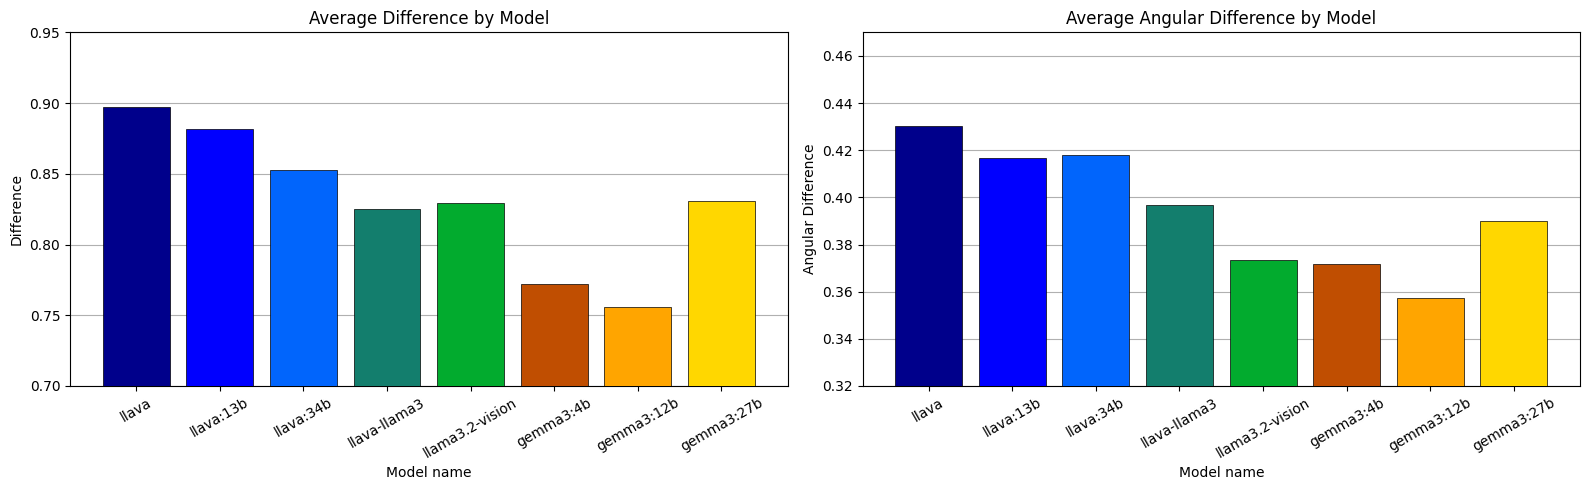

In [10]:
plt.figure(figsize=(16, 5))
colors = ["darkblue", "blue", "#0165fc", "#137e6d", "#02ab2e", "#c04e01", "orange", "gold"]

plt.subplot(1, 2, 1)
plt.grid(axis="y")
for i, model_name in enumerate(responses["model"].unique()):
    plt.bar(
        model_name,
        responses[responses["model"] == model_name]["difference"].mean(),
        zorder=5,
        color=colors[i % len(colors)],
        edgecolor="black",
        linewidth=0.5,   
    )

plt.ylim(0.7, 0.95)
plt.title("Average Difference by Model")
plt.xlabel("Model name")
plt.ylabel("Difference")
plt.xticks(rotation=30)

plt.subplot(1, 2, 2)
plt.grid(axis="y")
for i, model_name in enumerate(responses["model"].unique()):
    plt.bar(
        model_name,
        responses[responses["model"] == model_name]["angular_difference"].mean(),
        zorder=5,
        color=colors[i % len(colors)],
        edgecolor="black",
        linewidth=0.5,   
    )

plt.ylim(0.32, 0.47)
plt.title("Average Angular Difference by Model")
plt.xlabel("Model name")
plt.ylabel("Angular Difference")
plt.xticks(rotation=30)

plt.tight_layout()
plt.show()


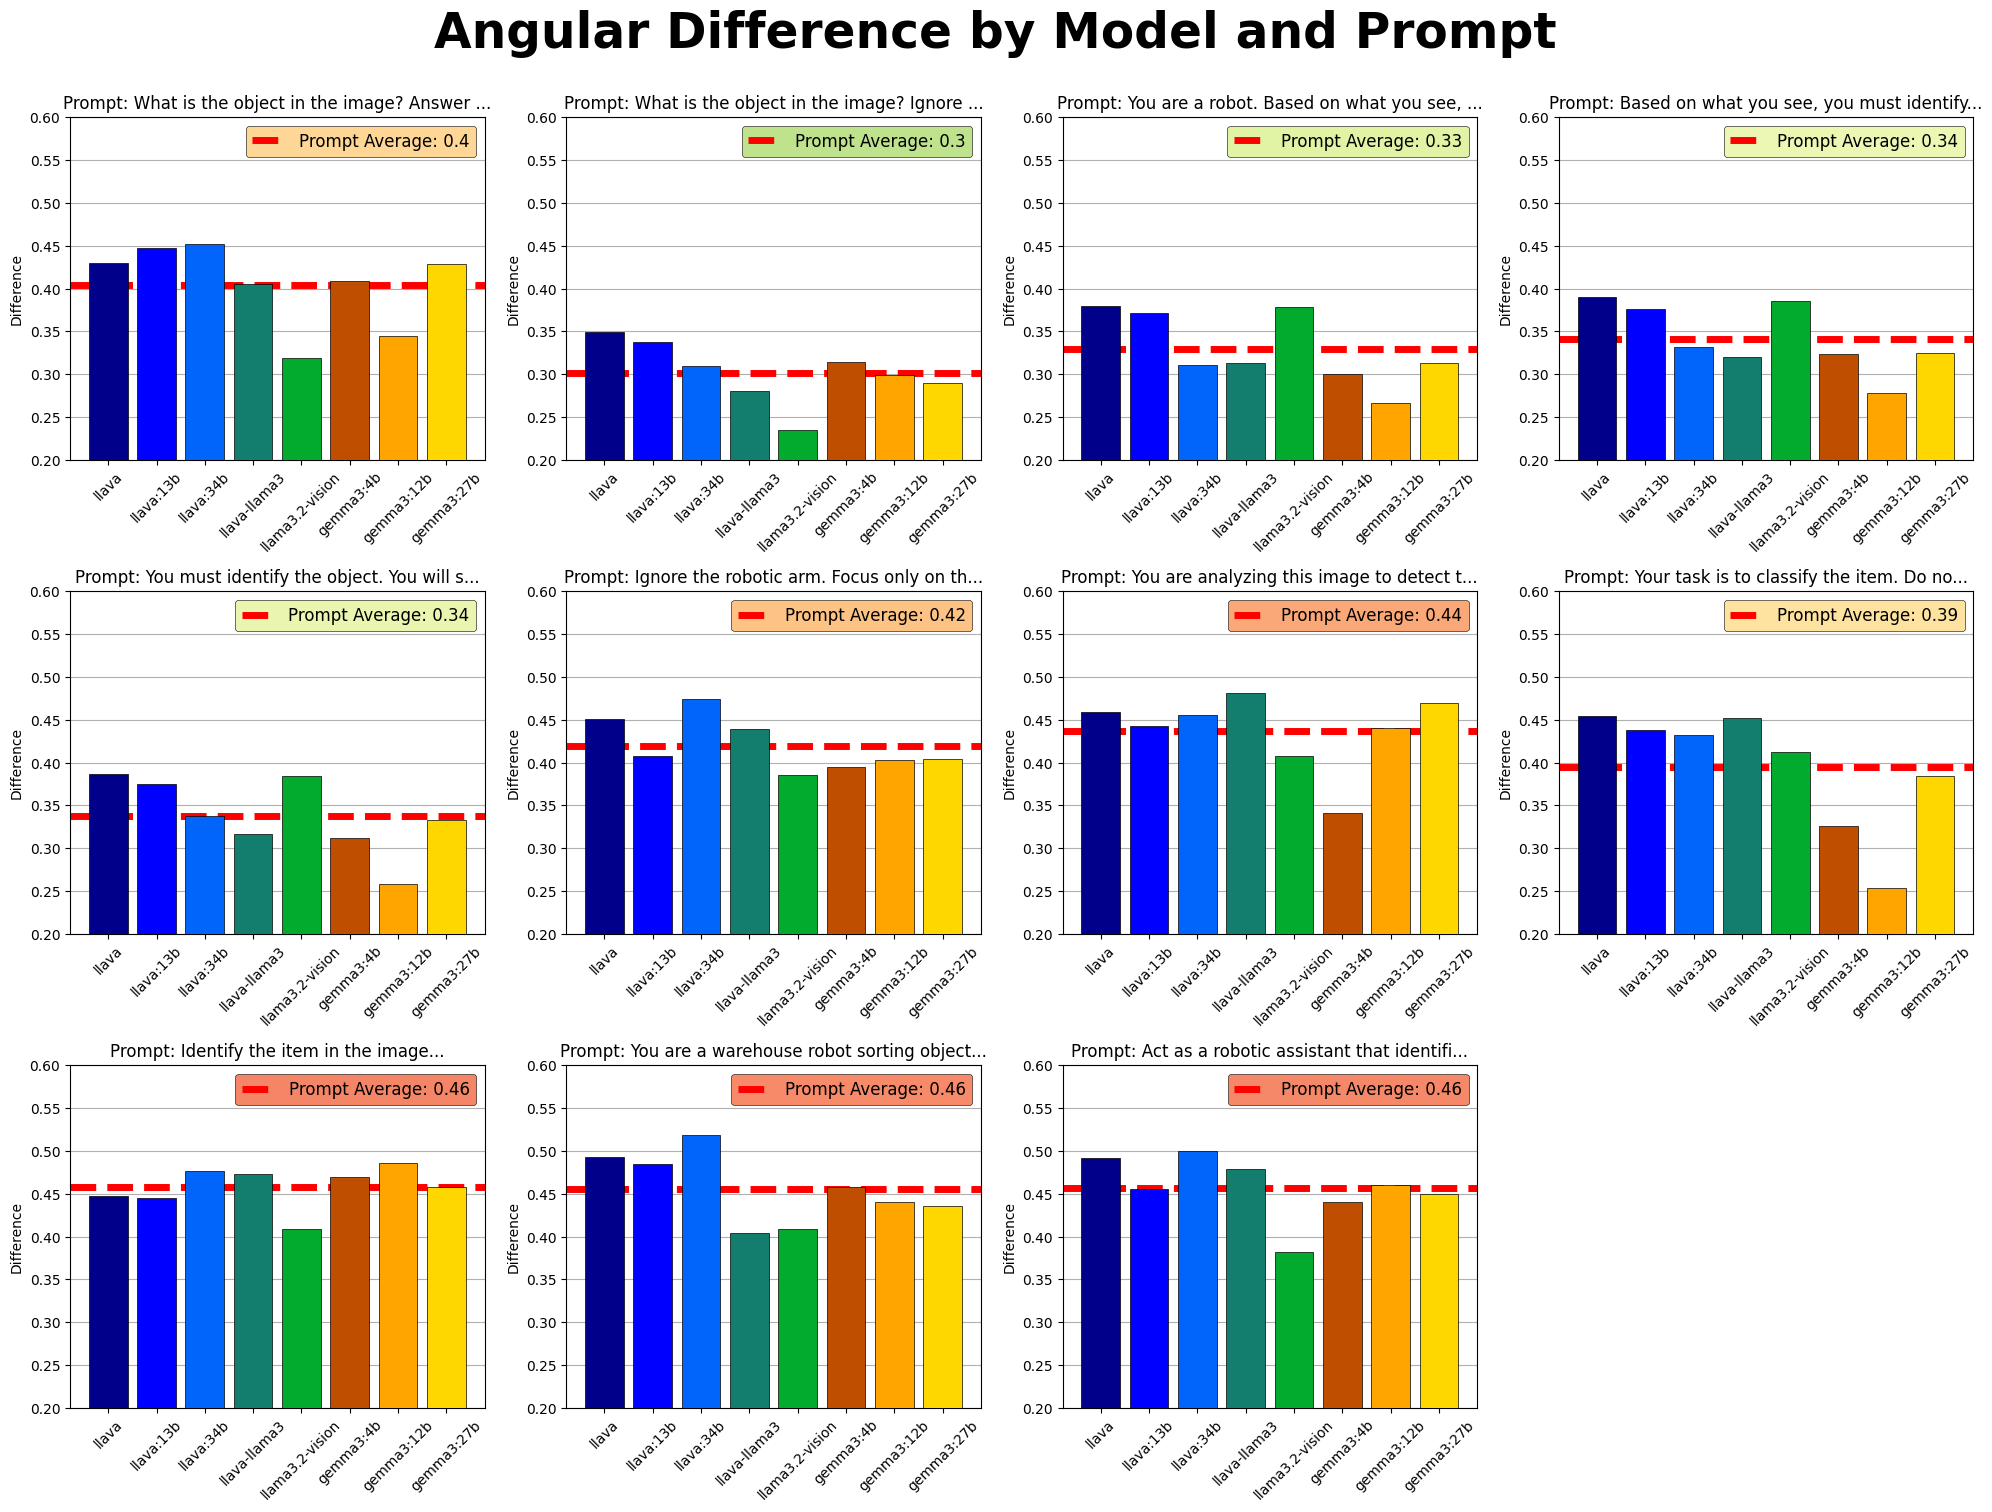

In [11]:
unique_prompts = responses["prompt"].unique()
colors = ["darkblue", "blue", "#0165fc", "#137e6d", "#02ab2e", "#c04e01", "orange", "gold"]
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten()

for idx, prompt in enumerate(unique_prompts[:12]):
    ax = axes[idx]
    ax.grid(axis="y")
    prompt_mean = 0
    for i, model_name in enumerate(responses["model"].unique()):
        differences = responses[(responses["prompt"] == prompt) & (responses["model"] == model_name)]["angular_difference"]
        ax.bar(
            model_name,
            differences.mean(),
            #label=model_name,
            zorder=5,
            color=colors[i % len(colors)],
            edgecolor="black",
            linewidth=0.5,   
        )
        prompt_mean += differences.mean()
    prompt_mean = prompt_mean / len(responses["model"].unique())
    ax.axhline(prompt_mean, color='red', lw=5, ls='--', label="Prompt Average: " + str(round(prompt_mean, 2)))
    
    ax.set_ylim(0.2, 0.6)
    ax.set_xticks(range(len(responses["model"].unique())))
    ax.set_xticklabels(responses["model"].unique(), rotation=45)
    ax.set_title(f"Prompt: {prompt[:40]}...")
    ax.set_ylabel("Difference")
    #ax.legend(fontsize=12)
    legend = ax.legend(fontsize=12)
    legend.get_frame().set_facecolor(plt.cm.RdYlGn_r((prompt_mean - 0.2) / (0.52 - 0.2)))
    legend.get_frame().set_edgecolor("black")
    legend.get_frame().set_linewidth(0.5)


for idx in range(len(unique_prompts), len(axes)):
    fig.delaxes(axes[idx])

plt.suptitle("Angular Difference by Model and Prompt", fontsize=35, fontweight='bold', y=1.005)
plt.tight_layout()
plt.show()

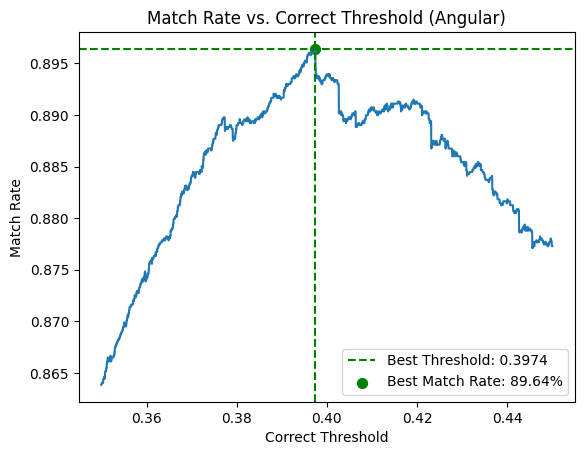

Best Threshold: 0.3974147414741474 | Match rate: 0.8964 | Correct rate: 0.4313 | Success rate: 0.4299


In [12]:
threshold_range = np.linspace(0.35, 0.45, 10000)

best_match_rate = 0
best_threshold = 0
best_correct_rate = 0
best_success_rate = 0

match_rates = []

for correct_threshold in threshold_range:
    corrects = np.array(responses["angular_difference"]) < correct_threshold
    successes = np.array(responses["success"])
    match_rate = np.mean(corrects == successes)
    match_rates.append(match_rate)
    if match_rate > best_match_rate:
        best_match_rate = match_rate
        best_threshold = correct_threshold
        best_correct_rate = np.mean(corrects)
        best_success_rate = np.mean(successes)

plt.plot(threshold_range, match_rates) #, label="Match Rate")
plt.axhline(y=best_match_rate, color='g', linestyle='--')
plt.axvline(x=best_threshold, color='g', linestyle='--', label="Best Threshold: " + str(round(best_threshold, 4)))
plt.scatter([best_threshold], [best_match_rate], color='g', s=50, label=f"Best Match Rate: {100*best_match_rate:.2f}%")

plt.title("Match Rate vs. Correct Threshold (Angular)")
plt.xlabel("Correct Threshold")
plt.ylabel("Match Rate")
plt.legend()
plt.show()

print(f"Best Threshold: {best_threshold} | Match rate: {best_match_rate:.4f} | Correct rate: {best_correct_rate:.4f} | Success rate: {best_success_rate:.4f}")

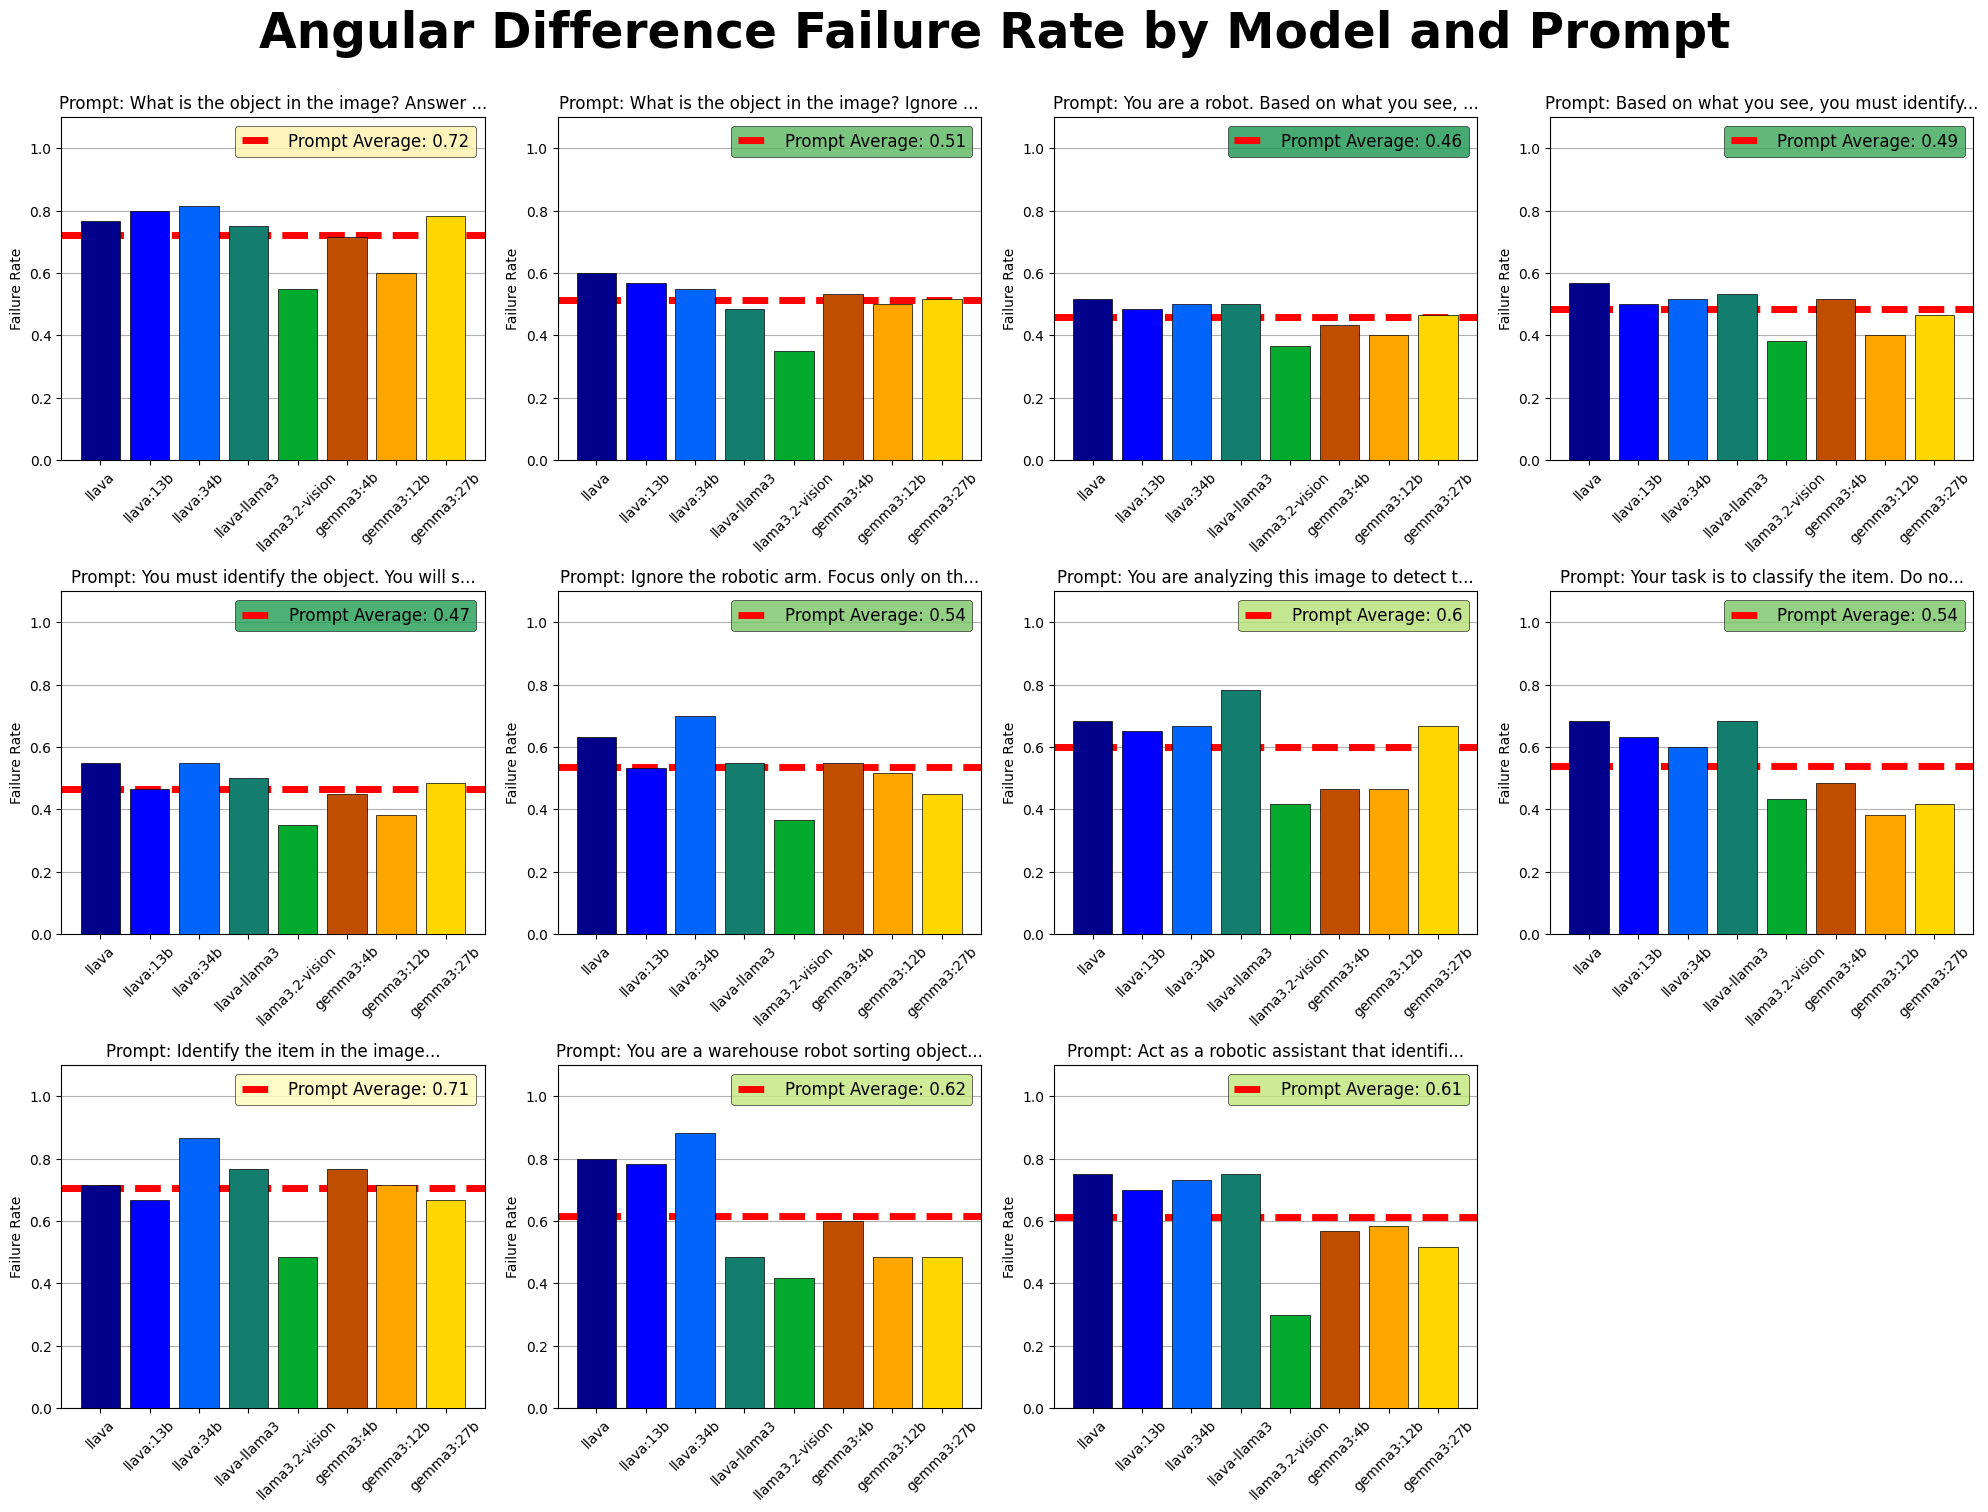

In [15]:
unique_prompts = responses["prompt"].unique()
colors = ["darkblue", "blue", "#0165fc", "#137e6d", "#02ab2e", "#c04e01", "orange", "gold"]
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten()

# ==========================
correct_threshold = 0.3974
# ==========================

for idx, prompt in enumerate(unique_prompts[:12]):
    ax = axes[idx]
    ax.grid(axis="y")
    prompt_mean = 0
    for i, model_name in enumerate(responses["model"].unique()):
        differences = responses[(responses["prompt"] == prompt) & (responses["model"] == model_name)]["angular_difference"]
        
        correct_guess_rate = 1 - np.mean(differences < correct_threshold)
        ax.bar(
            model_name,
            correct_guess_rate,
            #label=model_name,
            zorder=5,
            color=colors[i % len(colors)],
            edgecolor="black",
            linewidth=0.5,   
        )
        prompt_mean += correct_guess_rate
    prompt_mean = prompt_mean / len(responses["model"].unique())
    ax.axhline(prompt_mean, color='red', lw=5, ls='--', label="Prompt Average: " + str(round(prompt_mean, 2)))
    
    ax.set_ylim(0, 1.1)
    ax.set_xticks(range(len(responses["model"].unique())))
    ax.set_xticklabels(responses["model"].unique(), rotation=45)
    ax.set_title(f"Prompt: {prompt[:40]}...")
    ax.set_ylabel("Failure Rate")
    #ax.legend(fontsize=12)
    legend = ax.legend(fontsize=12)
    legend.get_frame().set_facecolor(plt.cm.RdYlGn_r((prompt_mean - 0.4) / (1 - 0.4)))
    legend.get_frame().set_edgecolor("black")
    legend.get_frame().set_linewidth(0.5)


for idx in range(len(unique_prompts), len(axes)):
    fig.delaxes(axes[idx])

plt.suptitle("Angular Difference Failure Rate by Model and Prompt", fontsize=35, fontweight='bold', y=1.005)
plt.tight_layout()
plt.show()

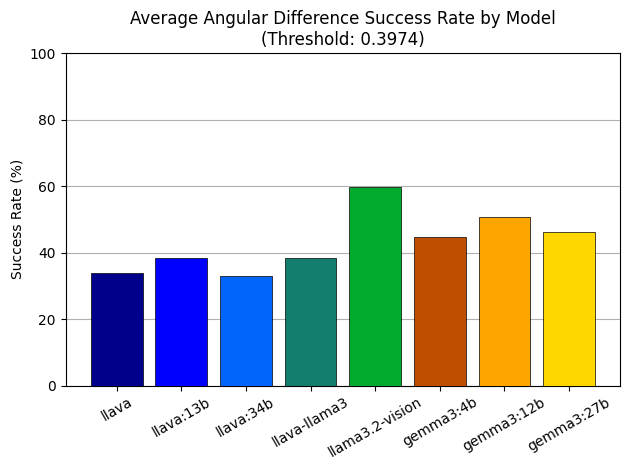

In [16]:
plt.grid(axis="y")
for i, model_name in enumerate(responses["model"].unique()):
    plt.bar(
        model_name,
        100 * np.mean(responses[responses["model"] == model_name]["angular_difference"] <= 0.3974),
        zorder=5,
        color=colors[i % len(colors)],
        edgecolor="black",
        linewidth=0.5,   
    )

plt.ylim(0, 100)
plt.title("Average Angular Difference Success Rate by Model\n(Threshold: 0.3974)")
plt.ylabel("Success Rate (%)")
plt.xticks(rotation=30)

plt.tight_layout()
plt.show()

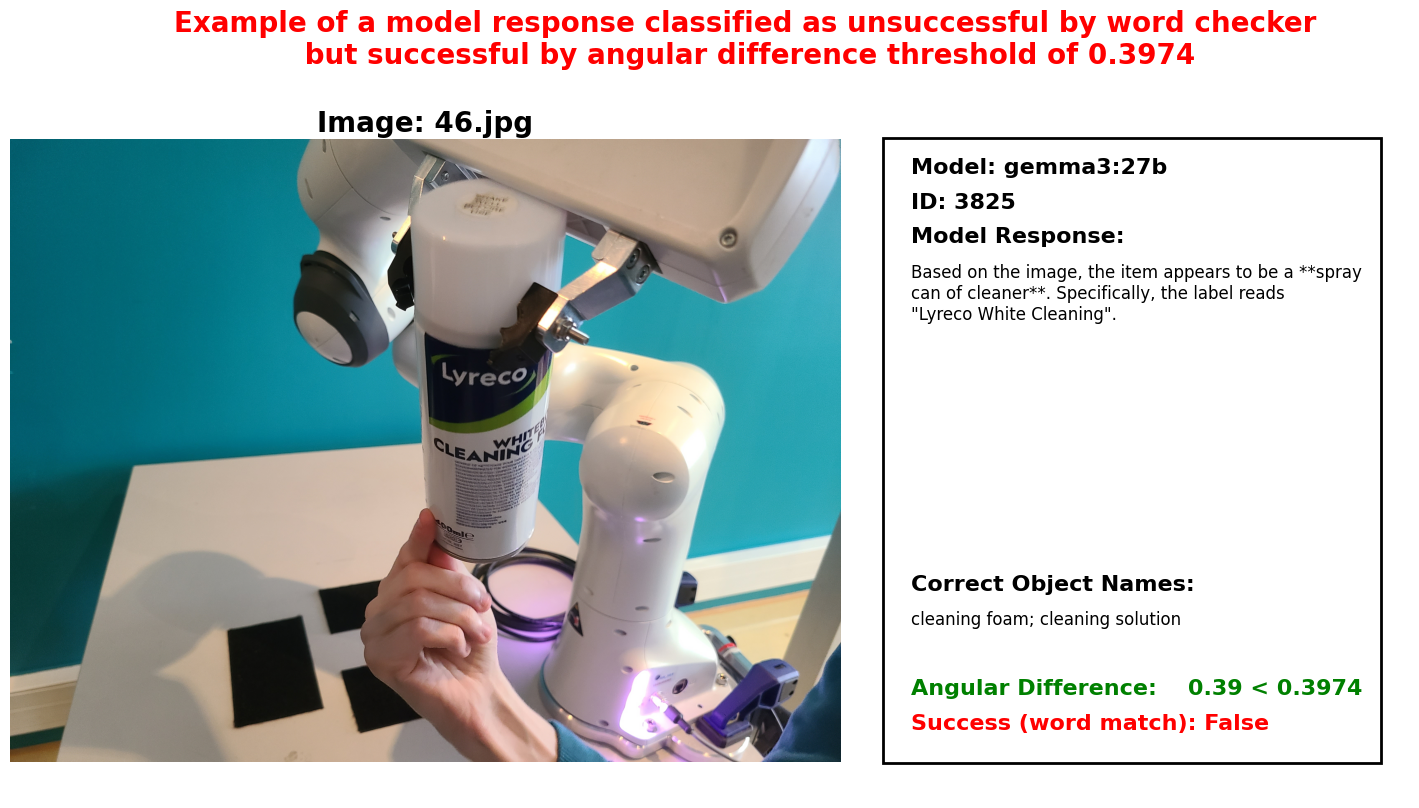

In [ ]:
ang_diff_threshold = 0.3974
corrects = np.array(responses["angular_difference"]) < ang_diff_threshold
successes = np.array(responses["success"])

different_indexes = np.where((corrects == True) & (successes == False))[0]
different_response = responses.iloc[different_indexes[np.random.randint(0, len(different_indexes))]]

image_path = "images/" + different_response["image_name"]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8), gridspec_kw={'width_ratios': [3, 2]})

try:
    image = Image.open(image_path)
    ax1.imshow(image)
    ax1.axis('off')
    ax1.set_title(f"Image: {different_response['image_name']}", fontsize=20, fontweight="bold")
except FileNotFoundError:
    ax1.text(0.5, 0.5, "Image not found", ha="center", va="center", fontsize=20)
    ax1.axis('off')

ax2.axis('off')
ax2.text(0.1, 0.9, f"Model: {different_response['model']}", fontsize=16, fontweight="bold")
ax2.text(0.1, 0.85, f"ID: {different_response.name}", fontsize=16, fontweight="bold")
ax2.text(0.1, 0.8, "Model Response:", fontsize=16, fontweight="bold")
wrapped_response = textwrap.fill(different_response["model_response"], width=53)
ax2.text(0.1, 0.77, wrapped_response, fontsize=12, verticalalignment="top")

ax2.text(0.1, 0.30, "Correct Object Names:", fontsize=16, fontweight="bold")
wrapped_objects = textwrap.fill(different_response["correct_object_names"], width=53)
ax2.text(0.1, 0.27, wrapped_objects, fontsize=12, verticalalignment="top")

ax2.text(0.1, 0.15, f"Angular Difference:    {different_response['angular_difference']:.2f} < {ang_diff_threshold}", fontsize=16, fontweight="bold", color="g")
ax2.text(0.1, 0.10, f"Success (word match): {different_response['success']}", fontsize=16, fontweight="bold", color="r")

ax2.add_patch(plt.Rectangle((0.05, 0.05), 0.9, 0.9, fill=False, edgecolor='black', linewidth=2))

plt.suptitle(f"Example of a model response classified as unsuccessful by word checker\n but successful by angular difference threshold of {ang_diff_threshold}", fontsize=20, fontweight="bold", color="red", y=1.005)
plt.tight_layout()
plt.show()

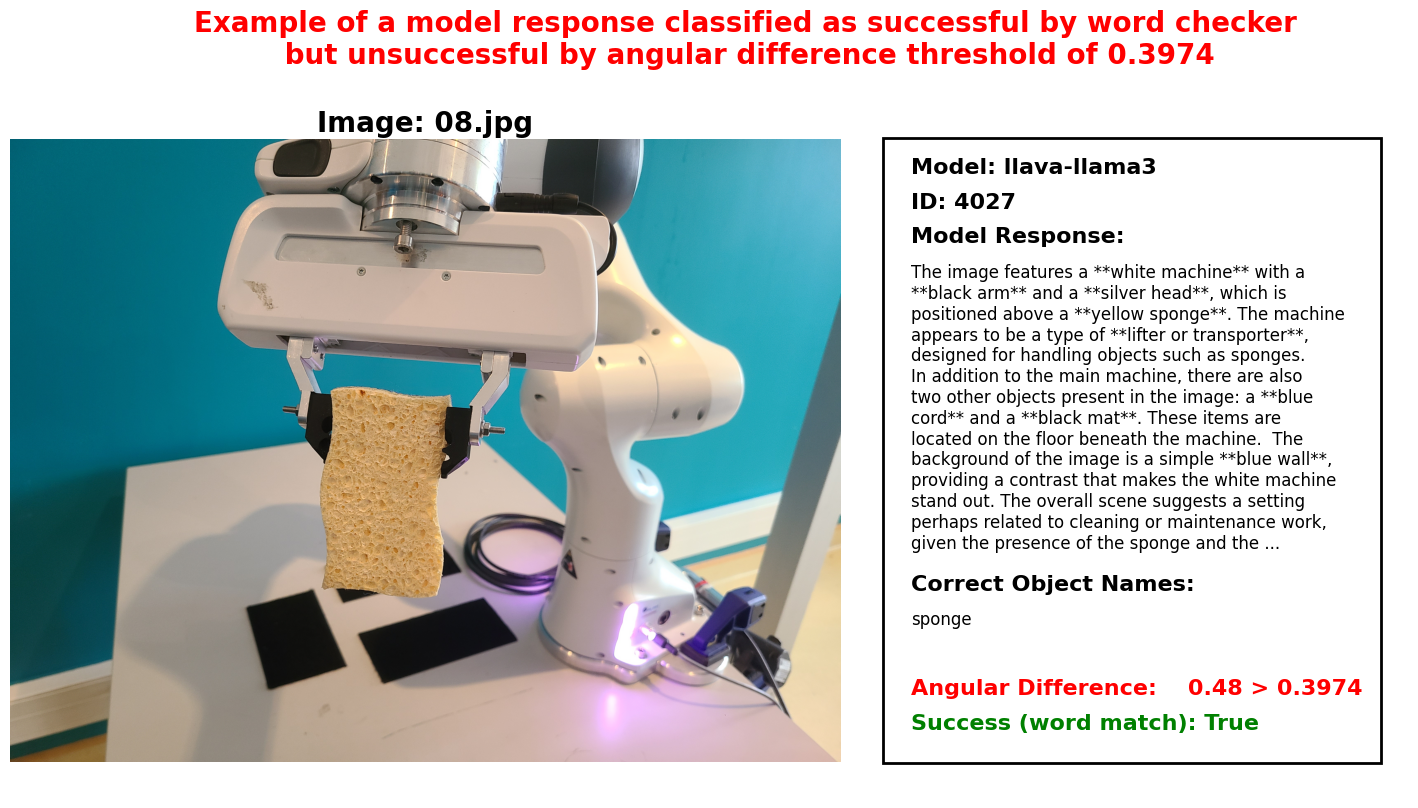

In [ ]:
ang_diff_threshold = 0.3974
corrects = np.array(responses["angular_difference"]) < ang_diff_threshold
successes = np.array(responses["success"])

different_indexes = np.where((corrects == False) & (successes == True))[0]
different_response = responses.iloc[different_indexes[np.random.randint(0, len(different_indexes))]]

image_path = "images/" + different_response["image_name"]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8), gridspec_kw={'width_ratios': [3, 2]})

try:
    image = Image.open(image_path)
    ax1.imshow(image)
    ax1.axis('off')
    ax1.set_title(f"Image: {different_response['image_name']}", fontsize=20, fontweight="bold")
except FileNotFoundError:
    ax1.text(0.5, 0.5, "Image not found", ha="center", va="center", fontsize=20)
    ax1.axis('off')

ax2.axis('off')
ax2.text(0.1, 0.9, f"Model: {different_response['model']}", fontsize=16, fontweight="bold")
ax2.text(0.1, 0.85, f"ID: {different_response.name}", fontsize=16, fontweight="bold")
ax2.text(0.1, 0.8, "Model Response:", fontsize=16, fontweight="bold")
wrapped_response = different_response["model_response"][:669] + "..." if len(different_response["model_response"]) > 665 else different_response["model_response"]
wrapped_response = textwrap.fill(wrapped_response, width=50)
ax2.text(0.1, 0.77, wrapped_response, fontsize=12, verticalalignment="top")

ax2.text(0.1, 0.30, "Correct Object Names:", fontsize=16, fontweight="bold")
wrapped_objects = textwrap.fill(different_response["correct_object_names"], width=50)
ax2.text(0.1, 0.27, wrapped_objects, fontsize=12, verticalalignment="top")

ax2.text(0.1, 0.15, f"Angular Difference:    {different_response['angular_difference']:.2f} > {ang_diff_threshold}", fontsize=16, fontweight="bold", color="r")
ax2.text(0.1, 0.10, f"Success (word match): {different_response['success']}", fontsize=16, fontweight="bold", color="g")

ax2.add_patch(plt.Rectangle((0.05, 0.05), 0.9, 0.9, fill=False, edgecolor='black', linewidth=2))

plt.suptitle(f"Example of a model response classified as successful by word checker\n but unsuccessful by angular difference threshold of {ang_diff_threshold}", fontsize=20, fontweight="bold", color="red", y=1.005)
plt.tight_layout()
plt.show()

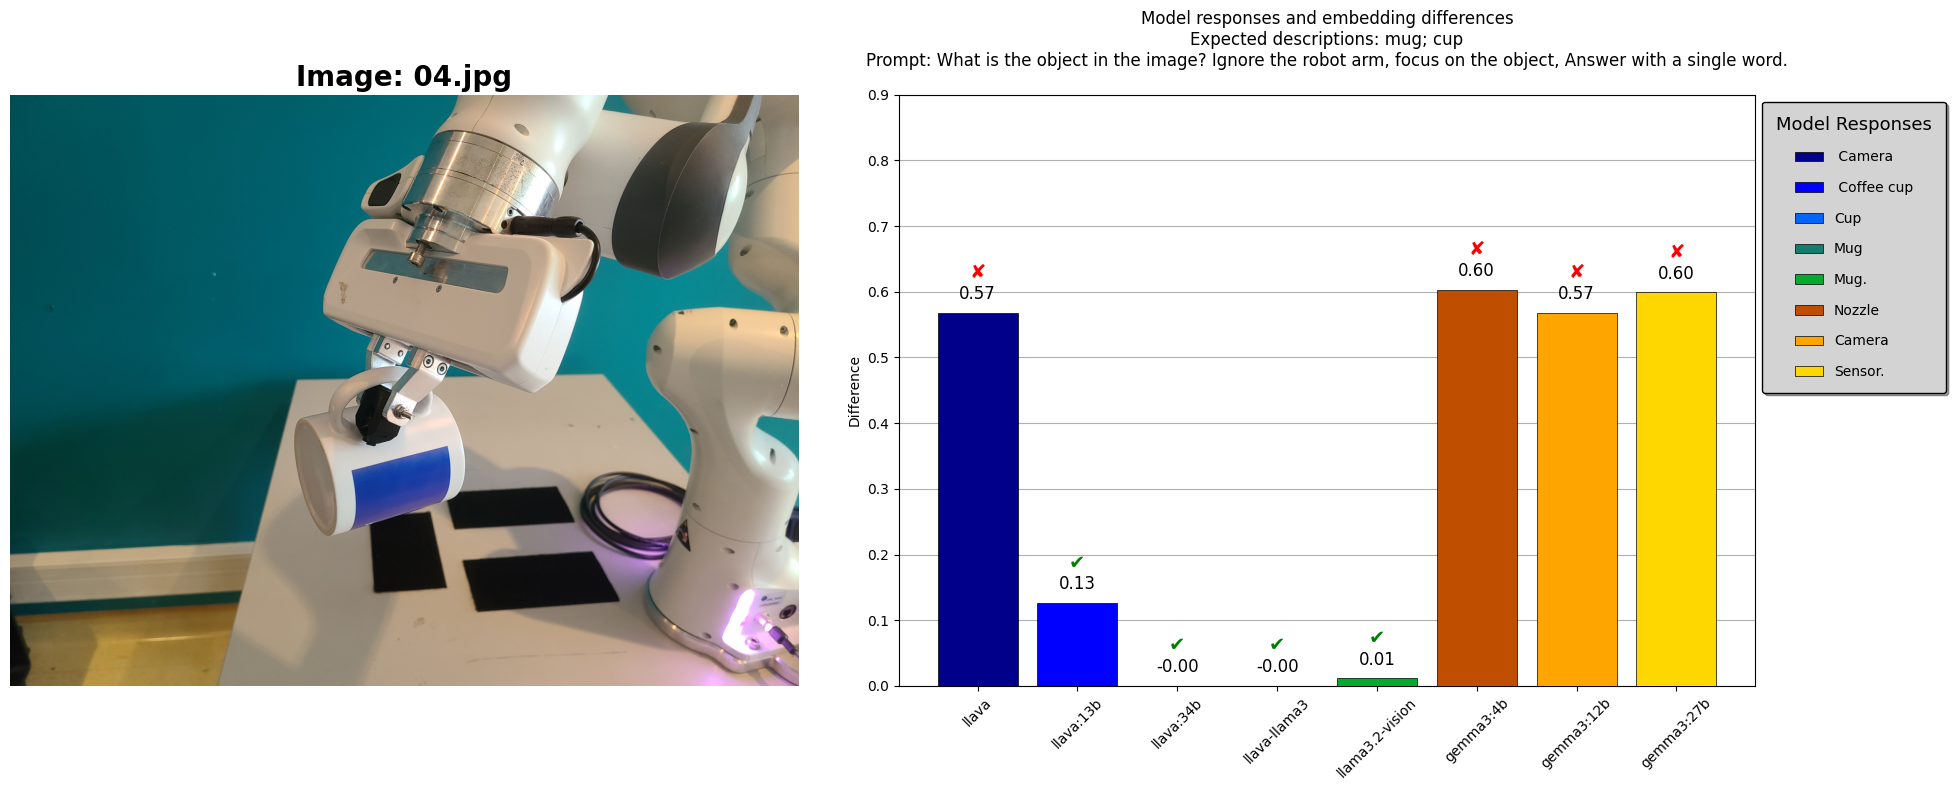

In [20]:
prompt_id = 1
photo_id = 3

compare_model_responses(responses, prompt_id, photo_id, diff_type="angular_difference")
print()

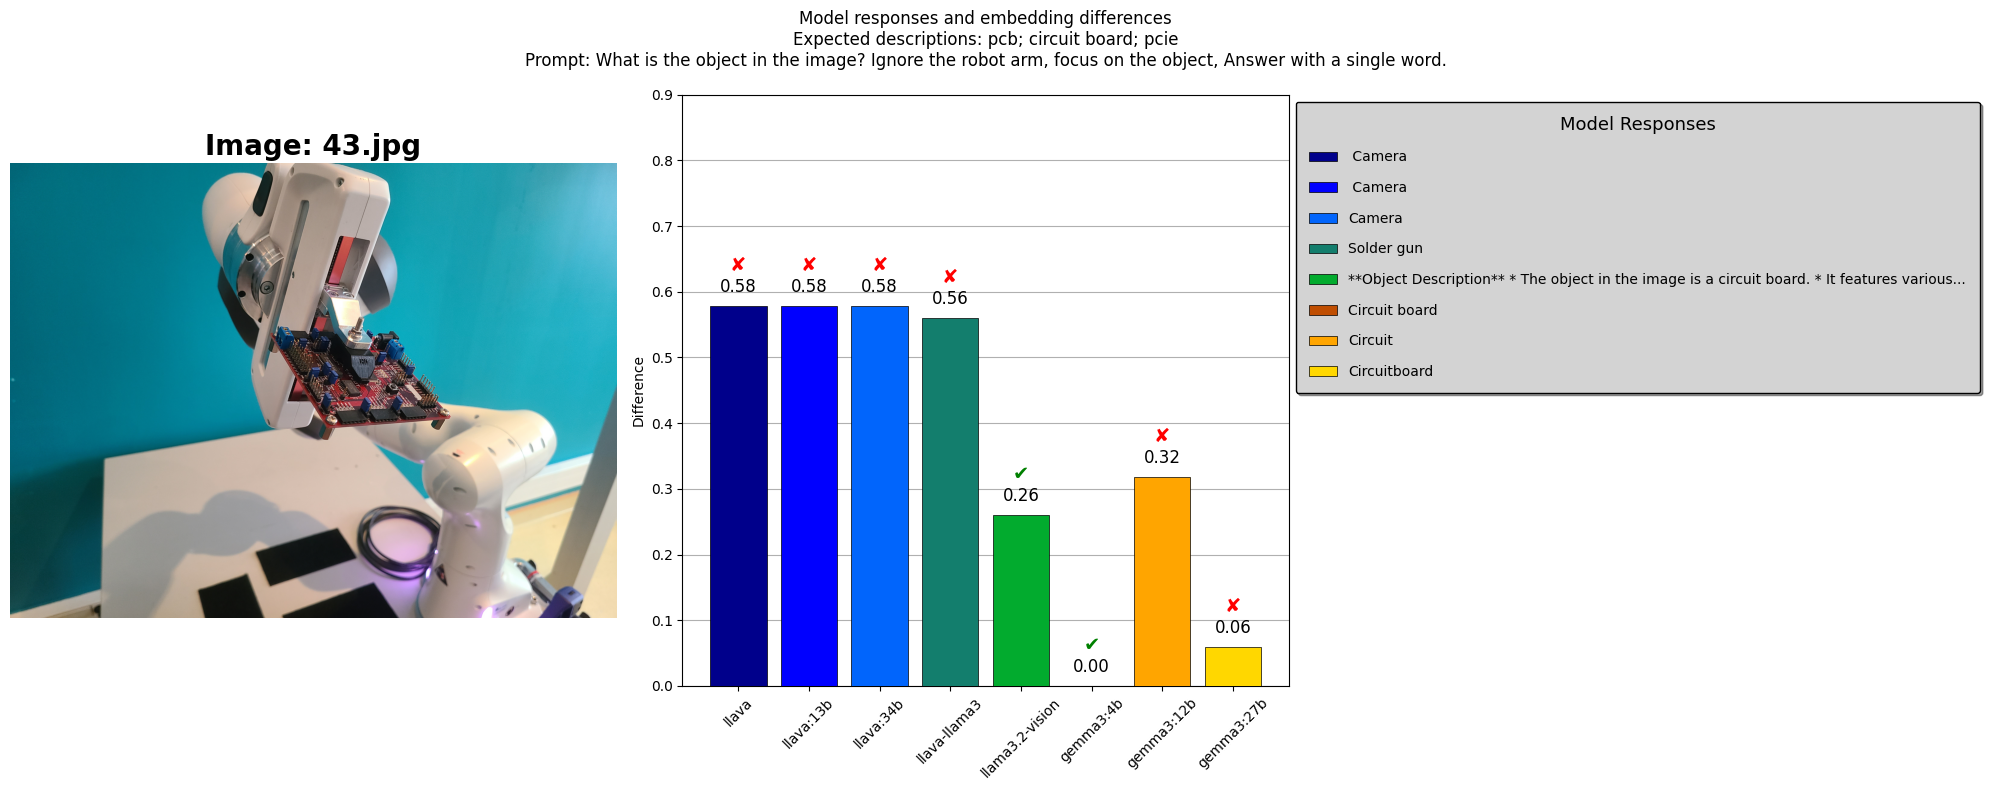

In [21]:
prompt_id = 1
photo_id = 42

compare_model_responses(responses, prompt_id, photo_id, diff_type="angular_difference")
print()

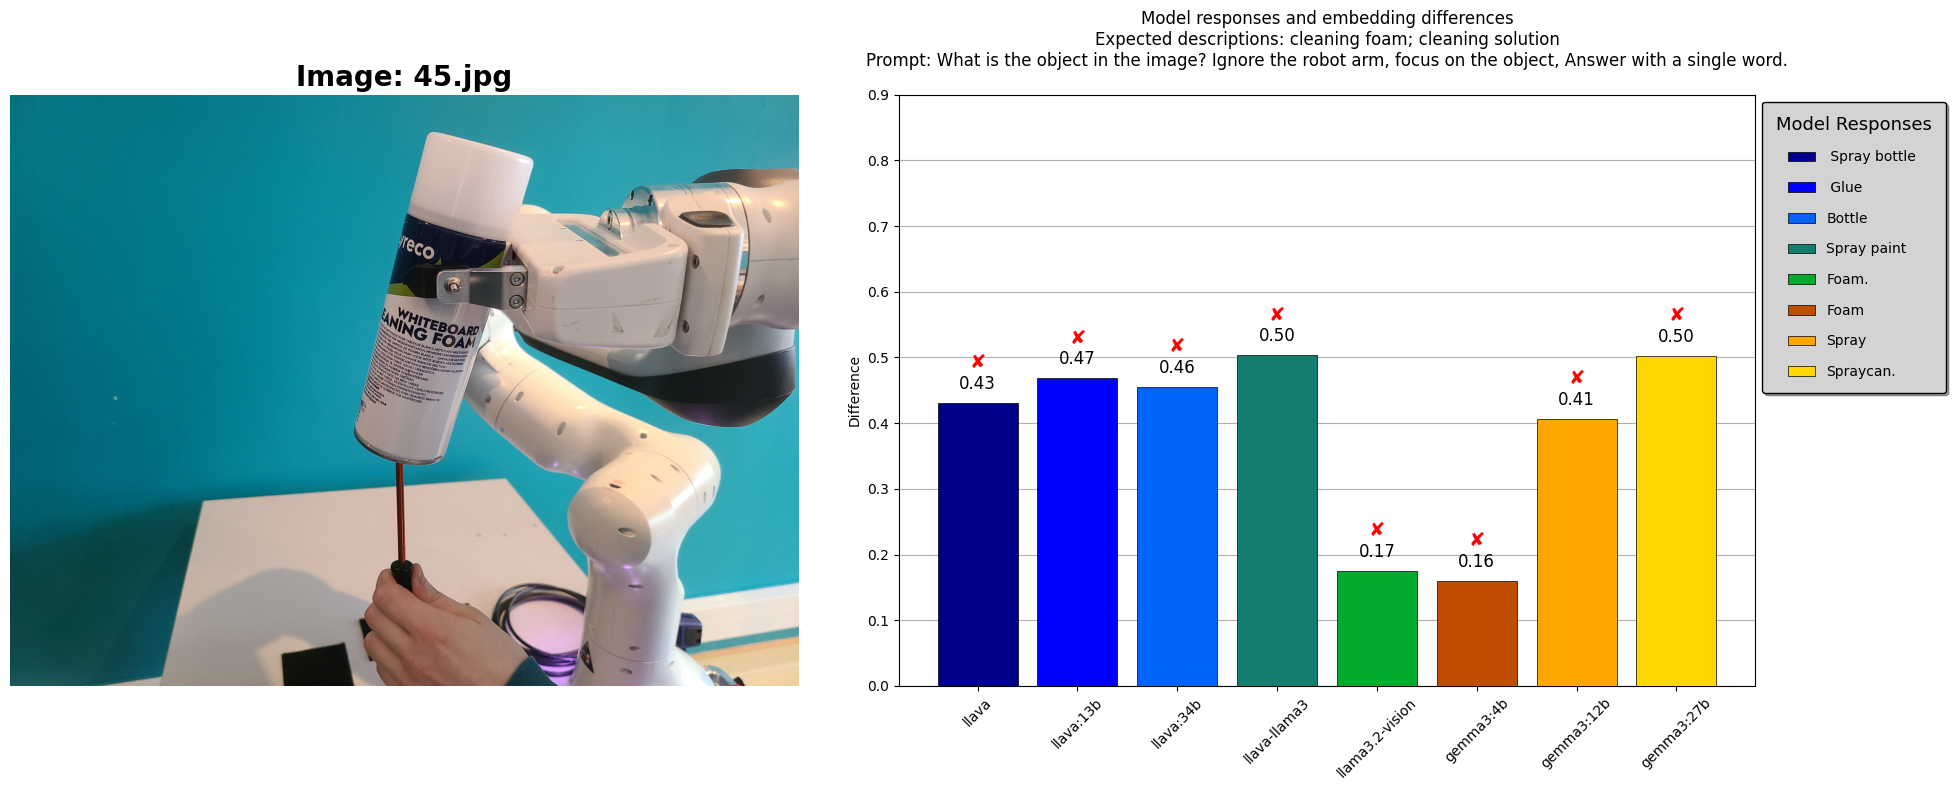

In [22]:
prompt_id = 1
photo_id = 44

compare_model_responses(responses, prompt_id, photo_id, diff_type="angular_difference")
print()

---

# Full Guesser Demo

---

In [24]:
indexes = [i for i in range(len(responses)) if int(responses.iloc[i]["image_name"][:2]) in range(49) and responses.iloc[i]["model"] == "llama3.2-vision"]

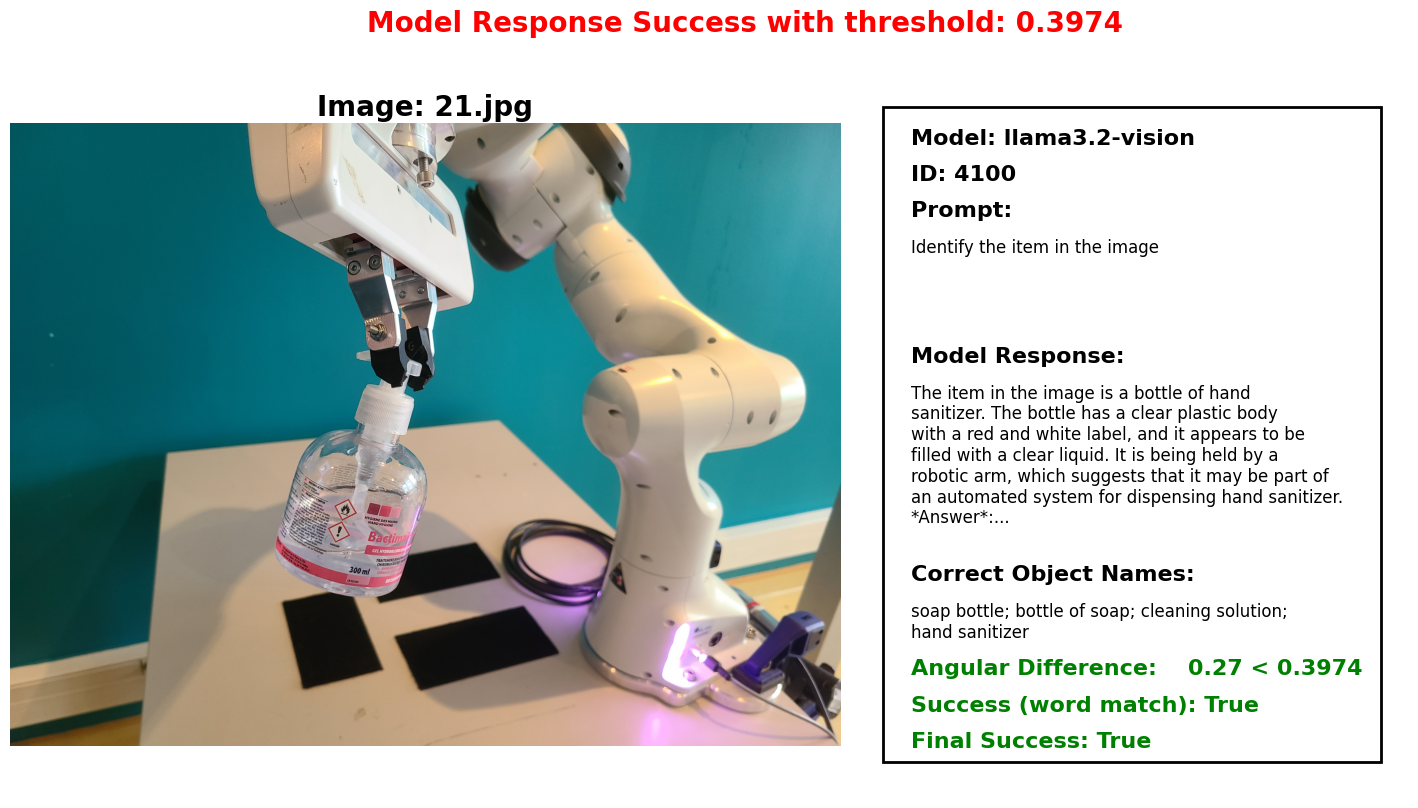

In [27]:
ang_diff_threshold = 0.3974
#full_guesser(responses, np.random.randint(0, len(responses)), threshold=0.3974)
full_guesser(responses, indexes[np.random.randint(0, len(indexes))], threshold=ang_diff_threshold)

---

# Full Guesser Stats

---

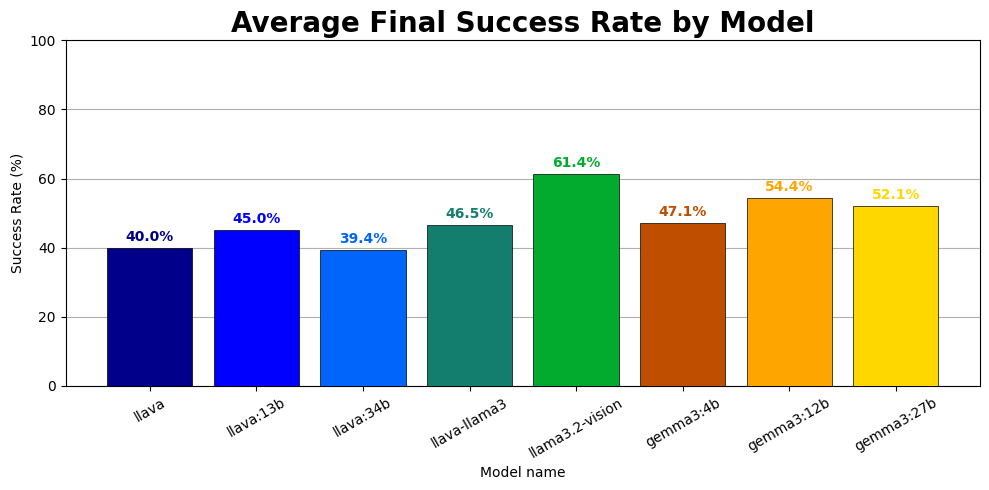

In [28]:
plt.figure(figsize=(10, 5))
colors = ["darkblue", "blue", "#0165fc", "#137e6d", "#02ab2e", "#c04e01", "orange", "gold"]

plt.grid(axis="y")
for i, model_name in enumerate(responses["model"].unique()):
    success_rate = responses[responses["model"] == model_name]["final_success"].mean()
    bar = plt.bar(
        model_name,
        success_rate * 100,
        zorder=5,
        color=colors[i % len(colors)],
        edgecolor="black",
        linewidth=0.5,   
    )
    plt.annotate(
        f'{success_rate:.1%}',
        xy=(i, success_rate*100),
        xytext=(0, 3),
        textcoords="offset points",
        ha='center',
        va='bottom',
        color=colors[i % len(colors)],
        fontweight='bold'
    )

plt.ylim(0, 100)
plt.title("Average Final Success Rate by Model", fontsize=20, fontweight='bold')
plt.xlabel("Model name")
plt.ylabel("Success Rate (%)")
plt.xticks(rotation=30)

plt.tight_layout()
plt.show()


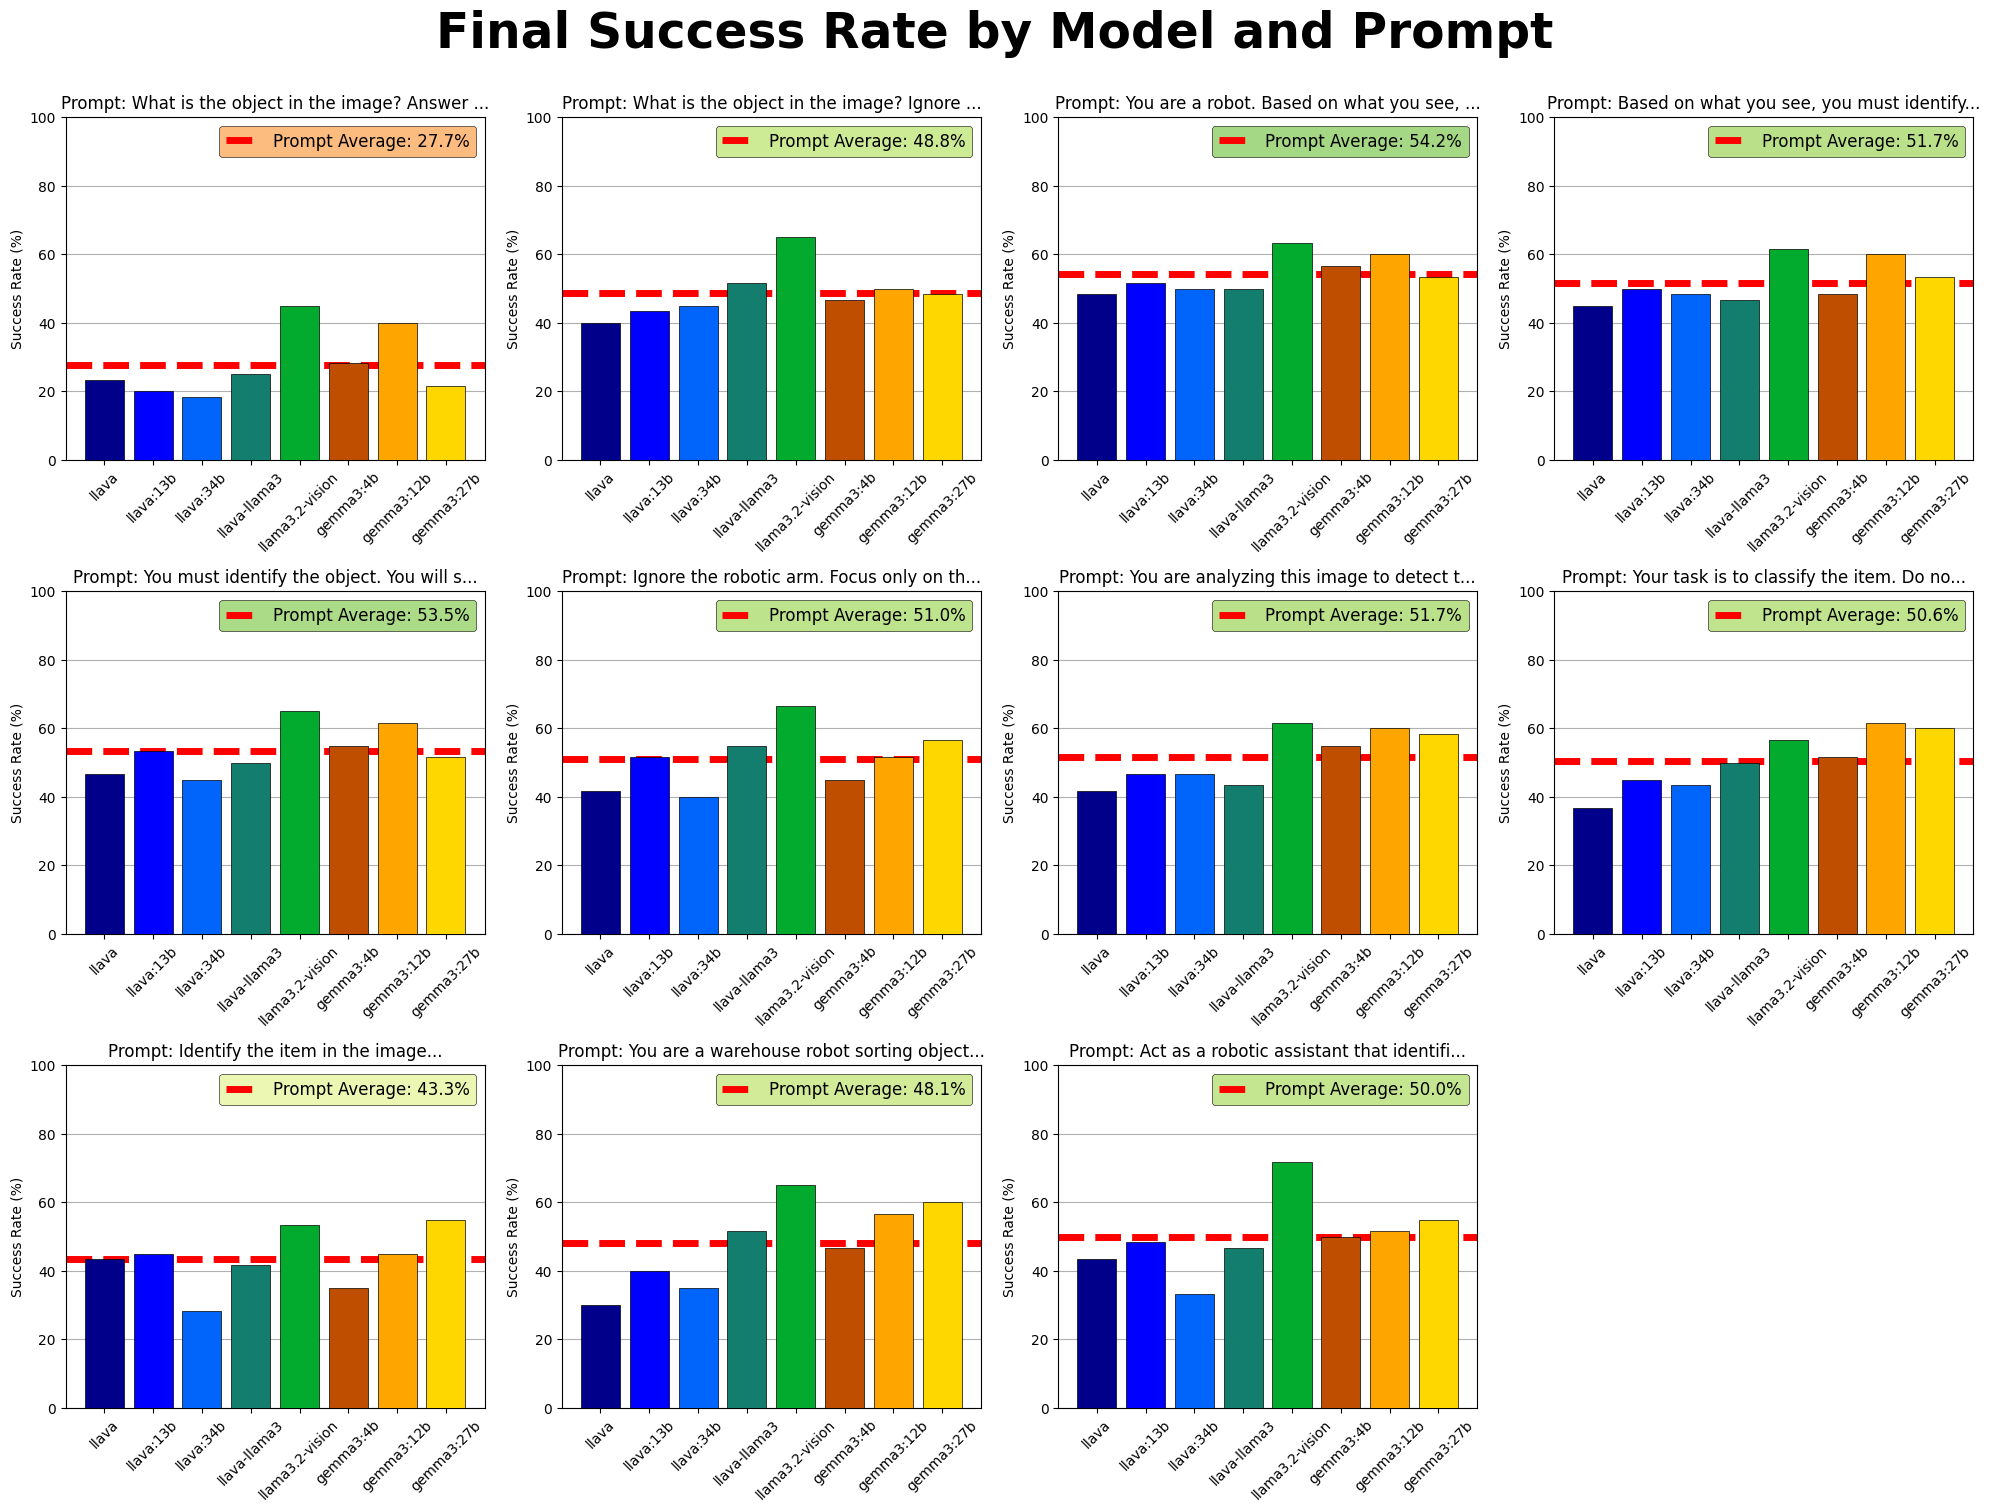

In [29]:
unique_prompts = responses["prompt"].unique()
colors = ["darkblue", "blue", "#0165fc", "#137e6d", "#02ab2e", "#c04e01", "orange", "gold"]
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten()

for idx, prompt in enumerate(unique_prompts[:12]):
    ax = axes[idx]
    ax.grid(axis="y")
    prompt_mean = 0
    for i, model_name in enumerate(responses["model"].unique()):
        differences = responses[(responses["prompt"] == prompt) & (responses["model"] == model_name)]["final_success"]
        
        correct_guess_rate = 100 * differences.mean()
        ax.bar(
            model_name,
            correct_guess_rate,
            #label=model_name,
            zorder=5,
            color=colors[i % len(colors)],
            edgecolor="black",
            linewidth=0.5,   
        )
        prompt_mean += correct_guess_rate
    prompt_mean = prompt_mean / len(responses["model"].unique())
    ax.axhline(prompt_mean, color='red', lw=5, ls='--', label="Prompt Average: " + str(round(prompt_mean, 1)) + "%")
    
    ax.set_ylim(0, 100)
    ax.set_xticks(range(len(responses["model"].unique())))
    ax.set_xticklabels(responses["model"].unique(), rotation=45)
    ax.set_title(f"Prompt: {prompt[:40]}...")
    ax.set_ylabel("Success Rate (%)")
    #ax.legend(fontsize=12)
    legend = ax.legend(fontsize=12)
    legend.get_frame().set_facecolor(plt.cm.RdYlGn((prompt_mean - 10) / (70 - 10)))
    legend.get_frame().set_edgecolor("black")
    legend.get_frame().set_linewidth(0.5)


for idx in range(len(unique_prompts), len(axes)):
    fig.delaxes(axes[idx])

plt.suptitle("Final Success Rate by Model and Prompt", fontsize=35, fontweight='bold', y=1.005)
plt.tight_layout()
plt.show()

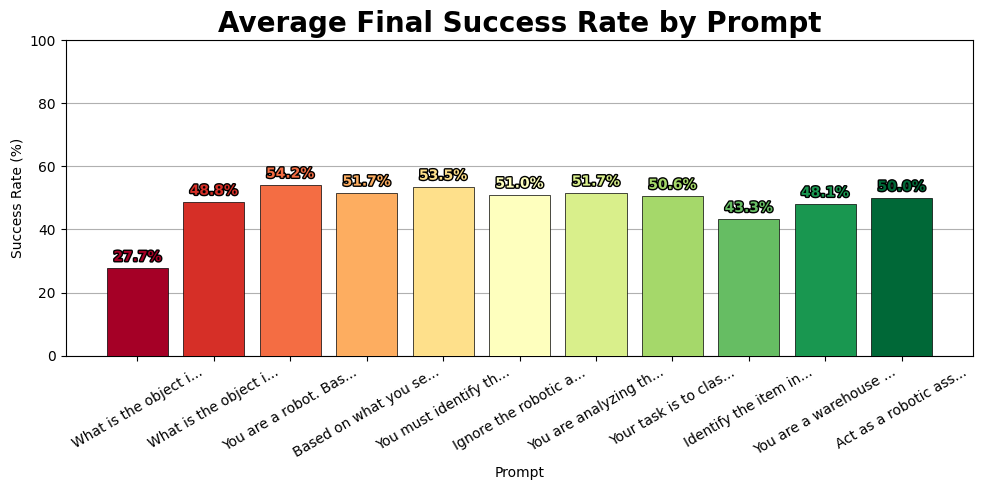

In [31]:
import matplotlib.patheffects as path_effects

plt.figure(figsize=(10, 5))
colors = plt.cm.RdYlGn(np.linspace(0, 1, len(responses["prompt"].unique())))
plt.grid(axis="y")

prompts = responses["prompt"].unique()
success_rates = []

for i, prompt in enumerate(prompts):
    success_rate = responses[responses["prompt"] == prompt]["final_success"].mean() * 100
    success_rates.append(success_rate)
    
    plt.bar(
        i,
        success_rate,
        zorder=5,
        color=colors[i],
        edgecolor="black",
        linewidth=0.5,   
    )
    
    plt.annotate(
        f'{success_rate:.1f}%',
        xy=(i, success_rate),
        xytext=(0, 3),
        textcoords="offset points",
        ha='center',
        va='bottom',
        color=colors[i],
        fontweight='bold',
        path_effects=[path_effects.withStroke(linewidth=2, foreground='black')]
    )

plt.ylim(0, 100)
plt.title("Average Final Success Rate by Prompt", fontsize=20, fontweight='bold')
plt.xlabel("Prompt")
plt.ylabel("Success Rate (%)")
plt.xticks(range(len(prompts)), [p[:20] + "..." for p in prompts], rotation=30)
plt.tight_layout()
plt.show()

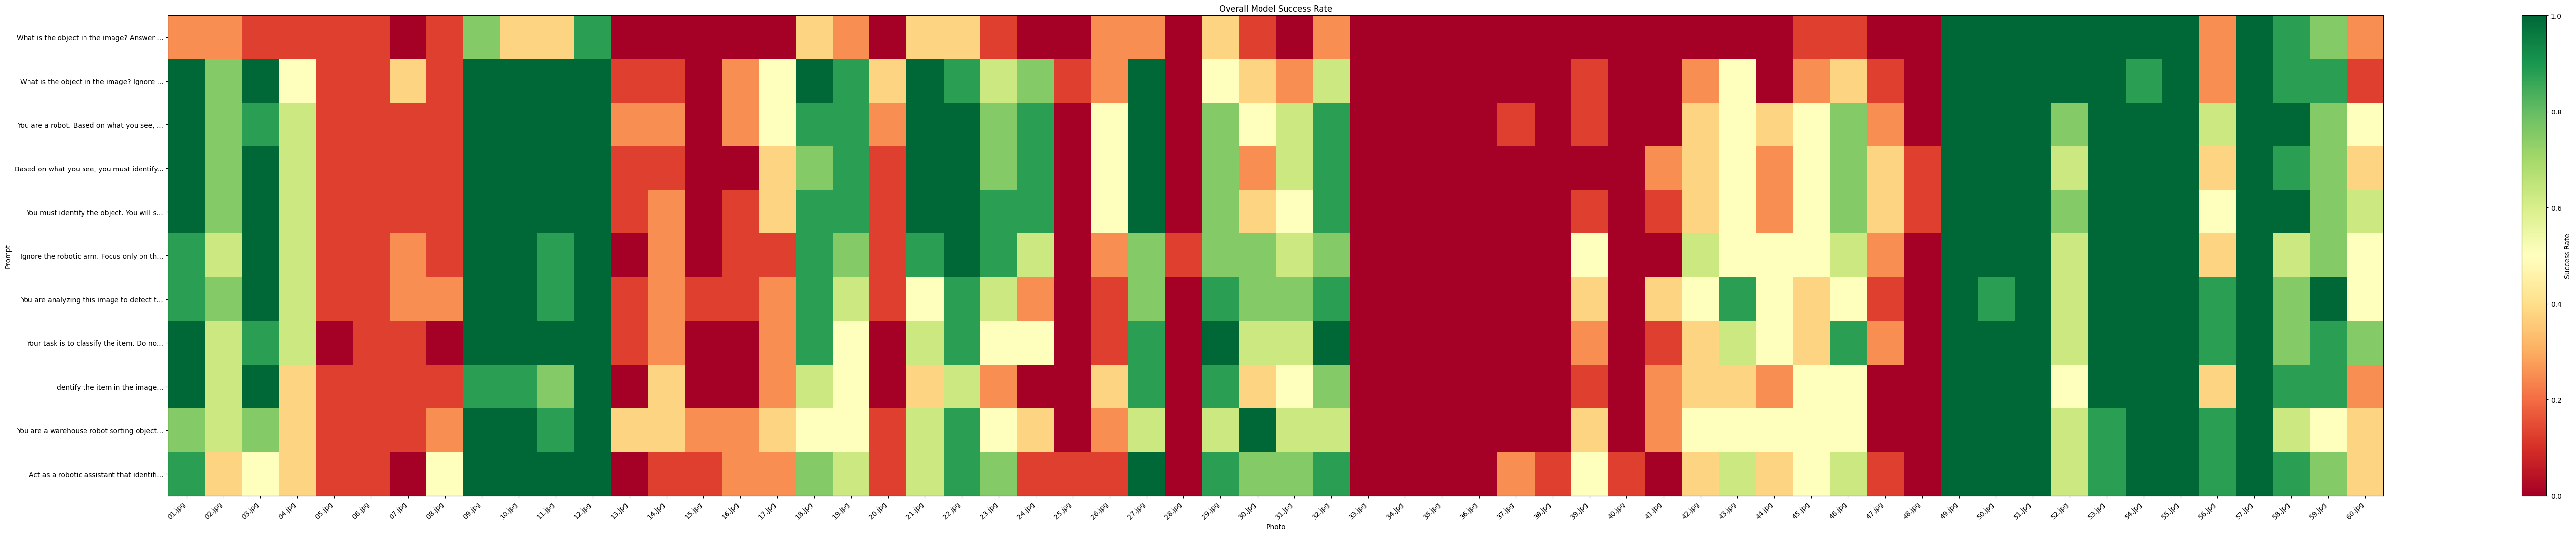

In [ ]:
def plot_overall_average_grid_allmodels(df, success_field="final_success"):
    unique_prompts = df["prompt"].unique()
    unique_photos = df["image_name"].unique()
    n_prompts = len(unique_prompts)
    n_photos = len(unique_photos)
    
    grid_data = np.zeros((n_prompts, n_photos))
    
    for i, prompt in enumerate(unique_prompts):
        for j, photo in enumerate(unique_photos):
            model_successes = []
            for model_name in df["model"].unique():
                # Get success value (0 or 1) for this model-prompt-image combination
                try:
                    model_success = df[(df["model"] == model_name) & 
                                      (df["prompt"] == prompt) & 
                                      (df["image_name"] == photo)][success_field].iloc[0]
                    model_successes.append(model_success)
                except IndexError:
                    # Skip if combination doesn't exist
                    pass
                    
            # Calculate success rate (ratio of successful models)
            if model_successes:
                grid_data[i, j] = np.mean(model_successes)
    
    plt.figure(figsize=(n_photos, n_prompts))
    plt.imshow(grid_data, cmap="RdYlGn", aspect="auto", interpolation="nearest", vmin=0, vmax=1)
    plt.colorbar(label="Success Rate")
    plt.xticks(range(n_photos), [photo[:10] for photo in unique_photos], rotation=45, ha="right")
    plt.yticks(range(n_prompts), [prompt[:40] + "..." for prompt in unique_prompts])
    plt.title(f"Overall Model Success Rate")
    plt.xlabel("Photo")
    plt.ylabel("Prompt")
    plt.tight_layout()
    #plt.savefig(f"output/overall_success_grid.png")
    plt.show()

plot_overall_average_grid_allmodels(responses, success_field="final_success")